#### EMACS LISP STUFF PLEASE IGNORE
(defun switch-to-notebook ()
 (interactive)
 (st-toggle-to-buffer "*ein: http://127.0.0.1:8899/make_figs.ipynb*"))

In [1]:
%pylab inline
import os,sys
from importlib import reload
from collections import defaultdict
from copy import deepcopy
plt.style.use("default")
plt.rcParams["figure.figsize"] = (8,3)
from matplotlib.gridspec import GridSpec
from scipy.signal import stft
from builtins import sum as bsum

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Don't reload this, otherwise it will create a new units registry object
# and will then complain about combining different registries.
import units; UNITS = units.UNITS

In [3]:
flush = lambda *args, **kwargs: [sys.stdout.flush(), print(*args, **kwargs)]

In [121]:
import boulder;   reload(boulder)
import crick;     reload(crick)
import surrogate; reload(surrogate)
import fisher_plumes_tools as fpt;      reload(fpt)
import fisher_plumes_figs  as fpf;      reload(fpf);
import fisher_plumes_fig_tools as fpft; reload(fpft)
import fisher_plumes as fp;             reload(fp)
import utils; reload(utils); from utils import dict_update, dict_update_from_field
FisherPlumes = fp.FisherPlumes

n_bootstraps = 50
pairs_mode = "unsigned"

crick.logger.setLevel(logging.DEBUG)
force_reload = False

include_cr = False

if force_reload or ('Fbw' not in locals()):
    Fbw = FisherPlumes("boulder16", pitch = 25000 * UNITS.um,
                       freq_max = 20 * UNITS.hertz,
                       which_coords = [(0.45, 0.5),
                                       #(0.35,0.5),
                                       #(0.25,0.5),
                                       #(0.15,0.5)
                                       ]*UNITS.m,
                       py_mode = "relative",
                       suffix  = "manuscript",
                       pairs_mode = pairs_mode, n_bootstraps = n_bootstraps, random_seed = 0)
else:
    Fbw = FisherPlumes(Fbw)
    Fbw.n_bootstraps = n_bootstraps

if include_cr:
    if force_reload or ('Fcr' not in locals()):
        Fcr = FisherPlumes("n12dishT",  pitch = 76000 * UNITS.um, freq_max = 100 * UNITS.hertz,
                           which_coords = [(1.0, 0.5),
                                           #(0.9,0.5),
    #                                       (0.7,0.5),
                                           #(0.6,0.5)
                                           ]*UNITS.m,
                           pairs_mode = pairs_mode, n_bootstraps = n_bootstraps, random_seed = 0)
    else:
        Fcr = FisherPlumes(Fcr)
        Fcr.n_bootstraps = n_bootstraps
    
if force_reload or ('Fsu' not in locals()):
    Fsu = FisherPlumes("surr_all_equal",
                       freq_max     = 20 * UNITS.hertz,
                       pitch        = 0.025 * UNITS.m,
                       which_coords = [(1.0, 0.)]*UNITS.m,
                       n_sources    = 16,
                       pairs_mode   = pairs_mode, n_bootstraps = n_bootstraps, random_seed = 1)    
else:
    Fsu = FisherPlumes(Fsu)
    Fsu.n_bootstraps = n_bootstraps

if force_reload or ('Fsu_white' not in locals()):
    Fsu_white = FisherPlumes("surr_all_equal",
                             freq_max     = 20 * UNITS.hertz,
                             pitch        = 0.025 * UNITS.m,
                             which_coords = [(1.0, 0.)]*UNITS.m,
                             n_sources    = 16,
                             pairs_mode   = pairs_mode, n_bootstraps = n_bootstraps, random_seed = 1,
                             surrogate_k = 0)    
else:
    Fsu_white = FisherPlumes(Fsu_white)
    Fsu_white.n_bootstraps = n_bootstraps
    
if force_reload or ('Fsu_high_white' not in locals()):
    Fsu_high_white = FisherPlumes("surr_high",
                       freq_max     = 20 * UNITS.hertz,
                       pitch        = 0.025 * UNITS.m,
                       which_coords = [(1.0, 0.)]*UNITS.m,
                       n_sources    = 16,
                       pairs_mode   = pairs_mode, n_bootstraps = n_bootstraps, random_seed = 1, surrogate_k = 0)    
else:
    Fsu_high_white = FisherPlumes(Fsu_high_white)
    Fsu_high_white.n_bootstraps = n_bootstraps    

if force_reload or ('Fsu_high_pink' not in locals()):
    Fsu_high_pink = FisherPlumes("surr_high",
                       freq_max     = 20 * UNITS.hertz,
                       pitch        = 0.025 * UNITS.m,
                       which_coords = [(1.0, 0.)]*UNITS.m,
                       n_sources    = 16,
                       pairs_mode   = pairs_mode, n_bootstraps = n_bootstraps, random_seed = 1, surrogate_k = 4)    
else:
    Fsu_high_pink = FisherPlumes(Fsu_high_pink)
    Fsu_high_pink.n_bootstraps = n_bootstraps

INFO:boulder:Boulder simulation data available for:


INFO:boulder:Re100_0_5mm_50Hz_16source_manuscript.h5         : ['Odor Data/c1a', 'Odor Data/c1b', 'Odor Data/c2a', 'Odor Data/c2b', 'Odor Data/c3a', 'Odor Data/c3b', 'Odor Data/c4a', 'Odor Data/c4b', 'Odor Data/c5a', 'Odor Data/c5b', 'Odor Data/c6a', 'Odor Data/c6b', 'Odor Data/c7a', 'Odor Data/c7b', 'Odor Data/c8a', 'Odor Data/c8b'] (16 datasets)


INFO:crick:Simulation data available for:


INFO:crick:ff_int_sym_slow_high_tres_wide_n12dishT         : Y0.450 - Y0.550 (11 datasets)


INFO:surrogate:Surrogate simulation data available for: ['no_info', 'one_info', 'two_info', 'high', 'spike_and_slab', 'blue', 'red', 'all_equal']


           fisher_plumes 2023/05/20 10:51:16     INFO: sim_name=<fisher_plumes.FisherPlumes object at 0x7f709dfce8e0> is a FisherPlumes object named boulder16.


           fisher_plumes 2023/05/20 10:51:16     INFO: Attempting to copy data fields.


           fisher_plumes 2023/05/20 10:51:16    DEBUG: Copied field name.


           fisher_plumes 2023/05/20 10:51:16    DEBUG: Copied field pitch.


           fisher_plumes 2023/05/20 10:51:16    DEBUG: Copied field pitch_string.


           fisher_plumes 2023/05/20 10:51:16    DEBUG: Copied field sims.


           fisher_plumes 2023/05/20 10:51:16    DEBUG: Copied field pairs_um.


           fisher_plumes 2023/05/20 10:51:16    DEBUG: Copied field n_bootstraps.


           fisher_plumes 2023/05/20 10:51:16    DEBUG: Copied field random_seed.


           fisher_plumes 2023/05/20 10:51:16    DEBUG: Copied field yvals_um.


           fisher_plumes 2023/05/20 10:51:16    DEBUG: Copied field pairs_mode.


           fisher_plumes 2023/05/20 10:51:16    DEBUG: Copied field wnd.


           fisher_plumes 2023/05/20 10:51:16    DEBUG: Copied field freq_max.


           fisher_plumes 2023/05/20 10:51:16    DEBUG: Copied field sim0.


           fisher_plumes 2023/05/20 10:51:16    DEBUG: Copied field fs.


           fisher_plumes 2023/05/20 10:51:16    DEBUG: Copied field dimensions.


           fisher_plumes 2023/05/20 10:51:16    DEBUG: Copied field freqs.


           fisher_plumes 2023/05/20 10:51:16    DEBUG: Copied field ss.


           fisher_plumes 2023/05/20 10:51:16    DEBUG: Copied field cc.


           fisher_plumes 2023/05/20 10:51:16    DEBUG: Copied field tt.


           fisher_plumes 2023/05/20 10:51:16    DEBUG: Copied field vars_for_freqs.


           fisher_plumes 2023/05/20 10:51:16    DEBUG: Copied field rho.


           fisher_plumes 2023/05/20 10:51:16    DEBUG: Copied field la.


           fisher_plumes 2023/05/20 10:51:16    DEBUG: Copied field mu.


           fisher_plumes 2023/05/20 10:51:16    DEBUG: Copied field pvals.


           fisher_plumes 2023/05/20 10:51:16    DEBUG: Copied field r2vals.


           fisher_plumes 2023/05/20 10:51:16    DEBUG: Copied field fit_params.


           fisher_plumes 2023/05/20 10:51:16    DEBUG: Copied field dd_fit.


           fisher_plumes 2023/05/20 10:51:16    DEBUG: Copied field I_dists.


           fisher_plumes 2023/05/20 10:51:16    DEBUG: Copied field I.


           fisher_plumes 2023/05/20 10:51:16    DEBUG: Copied field Ilow.


           fisher_plumes 2023/05/20 10:51:16    DEBUG: Copied field Ihigh.


           fisher_plumes 2023/05/20 10:51:16    DEBUG: Copied field I_pcs.


           fisher_plumes 2023/05/20 10:51:16    DEBUG: Copied field reg_freq_range.


           fisher_plumes 2023/05/20 10:51:16    DEBUG: Copied field reg_coefs.


           fisher_plumes 2023/05/20 10:51:16     INFO: Copied data fields from FisherPlumes object.


           fisher_plumes 2023/05/20 10:51:16     INFO: sim_name=<fisher_plumes.FisherPlumes object at 0x7f709ee67b80> is a FisherPlumes object named surr_all_equal.


           fisher_plumes 2023/05/20 10:51:16     INFO: Attempting to copy data fields.


           fisher_plumes 2023/05/20 10:51:16    DEBUG: Copied field name.


           fisher_plumes 2023/05/20 10:51:16    DEBUG: Copied field pitch.


           fisher_plumes 2023/05/20 10:51:16    DEBUG: Copied field pitch_string.


           fisher_plumes 2023/05/20 10:51:16    DEBUG: Copied field sims.


           fisher_plumes 2023/05/20 10:51:16    DEBUG: Copied field pairs_um.


           fisher_plumes 2023/05/20 10:51:16    DEBUG: Copied field n_bootstraps.


           fisher_plumes 2023/05/20 10:51:16    DEBUG: Copied field random_seed.


           fisher_plumes 2023/05/20 10:51:16    DEBUG: Copied field yvals_um.


           fisher_plumes 2023/05/20 10:51:16    DEBUG: Copied field pairs_mode.


           fisher_plumes 2023/05/20 10:51:16    DEBUG: Copied field wnd.


           fisher_plumes 2023/05/20 10:51:16    DEBUG: Copied field freq_max.


           fisher_plumes 2023/05/20 10:51:16    DEBUG: Copied field sim0.


           fisher_plumes 2023/05/20 10:51:16    DEBUG: Copied field fs.


           fisher_plumes 2023/05/20 10:51:16    DEBUG: Copied field dimensions.


           fisher_plumes 2023/05/20 10:51:16    DEBUG: Copied field freqs.


           fisher_plumes 2023/05/20 10:51:16    DEBUG: Copied field ss.


           fisher_plumes 2023/05/20 10:51:16    DEBUG: Copied field cc.


           fisher_plumes 2023/05/20 10:51:16    DEBUG: Copied field tt.


           fisher_plumes 2023/05/20 10:51:16    DEBUG: Copied field vars_for_freqs.


           fisher_plumes 2023/05/20 10:51:16    DEBUG: Copied field rho.


           fisher_plumes 2023/05/20 10:51:16    DEBUG: Copied field la.


           fisher_plumes 2023/05/20 10:51:16    DEBUG: Copied field mu.


           fisher_plumes 2023/05/20 10:51:16    DEBUG: Copied field pvals.


           fisher_plumes 2023/05/20 10:51:16    DEBUG: Copied field r2vals.


           fisher_plumes 2023/05/20 10:51:16    DEBUG: Copied field fit_params.


           fisher_plumes 2023/05/20 10:51:16    DEBUG: Copied field dd_fit.


           fisher_plumes 2023/05/20 10:51:16    DEBUG: Copied field I_dists.


           fisher_plumes 2023/05/20 10:51:16    DEBUG: Copied field I.


           fisher_plumes 2023/05/20 10:51:16    DEBUG: Copied field Ilow.


           fisher_plumes 2023/05/20 10:51:16    DEBUG: Copied field Ihigh.


           fisher_plumes 2023/05/20 10:51:16    DEBUG: Copied field I_pcs.


           fisher_plumes 2023/05/20 10:51:16    DEBUG: Copied field reg_freq_range.


           fisher_plumes 2023/05/20 10:51:16    DEBUG: Copied field reg_coefs.


           fisher_plumes 2023/05/20 10:51:16     INFO: Copied data fields from FisherPlumes object.


           fisher_plumes 2023/05/20 10:51:16     INFO: ****** LOADING sim_name='surr_all_equal' ******


           fisher_plumes 2023/05/20 10:51:16     INFO: 1 surr_all_equal_pitch = 0.025 m


           fisher_plumes 2023/05/20 10:51:16     INFO: 1 surr_all_equal_pitch = 2.5 cm


           fisher_plumes 2023/05/20 10:51:16     INFO: 1 surr_all_equal_pitch = 25.0 mm


           fisher_plumes 2023/05/20 10:51:16     INFO: 1 surr_all_equal_pitch = 25000.0 µm


INFO:surrogate:load_sims called for name='all_equal' with pitch_units=<Quantity(1, 'surr_all_equal_pitch')>


     fisher_plumes_tools 2023/05/20 10:51:16     INFO: Using absolute py coordinates.


INFO:surrogate:
all_equal <class 'surrogate.SurrogateSimulationData'>
1 surr_all_equal_pitch = 0.025 m
x_lim: 10 surr_all_equal_pitch to 10 surr_all_equal_pitch
y_lim: 0 surr_all_equal_pitch to 0 surr_all_equal_pitch
x-y Dimensions: [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>]
x-range: 10.000 surr_all_equal_pitch, ... 10.000 surr_all_equal_pitch (1 points)
y-range: 0.000 surr_all_equal_pitch, ... 0.000 surr_all_equal_pitch (1 points)
fs: 50 hertz
Sources:
  0: =     S0 @ (x = +0 micrometer, y = -56250 micrometer)
  1: =     S1 @ (x = +0 micrometer, y = -48750 micrometer)
  2: =     S2 @ (x = +0 micrometer, y = -41250 micrometer)
  3: =     S3 @ (x = +0 micrometer, y = -33750 micrometer)
  4: =     S4 @ (x = +0 micrometer, y = -26250 micrometer)
  5: =     S5 @ (x = +0 micrometer, y = -18750 micrometer)
  6: =     S6 @ (x = +0 micrometer, y = -11250 micrometer)
  7: =     S7 @ (x = +0 micrometer, y = -3750 micrometer)
  8: =     S8 @ (x = +0 micrometer,

INFO:surrogate:Mapped coordinate (1.000 meter, 0.000 meter) to (10.000 surr_all_equal_pitch, 0.000 surr_all_equal_pitch), index (0, 0), name '@origin'.


INFO:surrogate:Generating surogate data where all frequencies are equally informative.


INFO:surrogate:Field S0 has shape (3001, 1).


INFO:surrogate:Field S1 has shape (3001, 1).


INFO:surrogate:Field S2 has shape (3001, 1).


INFO:surrogate:Field S3 has shape (3001, 1).


INFO:surrogate:Field S4 has shape (3001, 1).


INFO:surrogate:Field S5 has shape (3001, 1).


INFO:surrogate:Field S6 has shape (3001, 1).


INFO:surrogate:Field S7 has shape (3001, 1).


INFO:surrogate:Field S8 has shape (3001, 1).


INFO:surrogate:Field S9 has shape (3001, 1).


INFO:surrogate:Field S10 has shape (3001, 1).


INFO:surrogate:Field S11 has shape (3001, 1).


INFO:surrogate:Field S12 has shape (3001, 1).


INFO:surrogate:Field S13 has shape (3001, 1).


INFO:surrogate:Field S14 has shape (3001, 1).


INFO:surrogate:Field S15 has shape (3001, 1).


INFO:surrogate:Generated surrogated data for 16 sources.


INFO:surrogate:t-range: 0.000 second, 0.020 second ... 60.000 second (3001 points)


     fisher_plumes_tools 2023/05/20 10:52:06     INFO: Computing pairs for len(yvals)=16 from -56250 to 56250 using pairs_mode='unsigned'.


     fisher_plumes_tools 2023/05/20 10:52:06     INFO: Removing duplicates in pairs dictionary.


           fisher_plumes 2023/05/20 10:52:06     INFO: list(self.sims.keys())=[-56250, -48750, -41250, -33750, -26250, -18750, -11250, -3750, 3750, 11250, 18750, 26250, 33750, 41250, 48750, 56250]


           fisher_plumes 2023/05/20 10:52:06     INFO: sim_name=<fisher_plumes.FisherPlumes object at 0x7f7108eefbb0> is a FisherPlumes object named surr_high.


           fisher_plumes 2023/05/20 10:52:06     INFO: Attempting to copy data fields.


           fisher_plumes 2023/05/20 10:52:06    DEBUG: Copied field name.


           fisher_plumes 2023/05/20 10:52:06    DEBUG: Copied field pitch.


           fisher_plumes 2023/05/20 10:52:06    DEBUG: Copied field pitch_string.


           fisher_plumes 2023/05/20 10:52:06    DEBUG: Copied field sims.


           fisher_plumes 2023/05/20 10:52:06    DEBUG: Copied field pairs_um.


           fisher_plumes 2023/05/20 10:52:06    DEBUG: Copied field n_bootstraps.


           fisher_plumes 2023/05/20 10:52:06    DEBUG: Copied field random_seed.


           fisher_plumes 2023/05/20 10:52:06    DEBUG: Copied field yvals_um.


           fisher_plumes 2023/05/20 10:52:06    DEBUG: Copied field pairs_mode.


           fisher_plumes 2023/05/20 10:52:06    DEBUG: Copied field wnd.


           fisher_plumes 2023/05/20 10:52:06    DEBUG: Copied field freq_max.


           fisher_plumes 2023/05/20 10:52:06    DEBUG: Copied field sim0.


           fisher_plumes 2023/05/20 10:52:06    DEBUG: Copied field fs.


           fisher_plumes 2023/05/20 10:52:06    DEBUG: Copied field dimensions.


           fisher_plumes 2023/05/20 10:52:06    DEBUG: Copied field freqs.


           fisher_plumes 2023/05/20 10:52:06    DEBUG: Copied field ss.


           fisher_plumes 2023/05/20 10:52:06    DEBUG: Copied field cc.


           fisher_plumes 2023/05/20 10:52:06    DEBUG: Copied field tt.


           fisher_plumes 2023/05/20 10:52:06    DEBUG: Copied field vars_for_freqs.


           fisher_plumes 2023/05/20 10:52:06    DEBUG: Copied field rho.


           fisher_plumes 2023/05/20 10:52:06    DEBUG: Copied field la.


           fisher_plumes 2023/05/20 10:52:06    DEBUG: Copied field mu.


           fisher_plumes 2023/05/20 10:52:06    DEBUG: Copied field pvals.


           fisher_plumes 2023/05/20 10:52:06    DEBUG: Copied field r2vals.


           fisher_plumes 2023/05/20 10:52:06    DEBUG: Copied field fit_params.


           fisher_plumes 2023/05/20 10:52:06    DEBUG: Copied field dd_fit.


           fisher_plumes 2023/05/20 10:52:06    DEBUG: Copied field I_dists.


           fisher_plumes 2023/05/20 10:52:06    DEBUG: Copied field I.


           fisher_plumes 2023/05/20 10:52:06    DEBUG: Copied field Ilow.


           fisher_plumes 2023/05/20 10:52:06    DEBUG: Copied field Ihigh.


           fisher_plumes 2023/05/20 10:52:06    DEBUG: Copied field I_pcs.


           fisher_plumes 2023/05/20 10:52:06    DEBUG: Copied field reg_freq_range.


           fisher_plumes 2023/05/20 10:52:06    DEBUG: Copied field reg_coefs.


           fisher_plumes 2023/05/20 10:52:06     INFO: Copied data fields from FisherPlumes object.


           fisher_plumes 2023/05/20 10:52:06     INFO: sim_name=<fisher_plumes.FisherPlumes object at 0x7f7108e11ee0> is a FisherPlumes object named surr_high.


           fisher_plumes 2023/05/20 10:52:06     INFO: Attempting to copy data fields.


           fisher_plumes 2023/05/20 10:52:06    DEBUG: Copied field name.


           fisher_plumes 2023/05/20 10:52:06    DEBUG: Copied field pitch.


           fisher_plumes 2023/05/20 10:52:06    DEBUG: Copied field pitch_string.


           fisher_plumes 2023/05/20 10:52:06    DEBUG: Copied field sims.


           fisher_plumes 2023/05/20 10:52:06    DEBUG: Copied field pairs_um.


           fisher_plumes 2023/05/20 10:52:06    DEBUG: Copied field n_bootstraps.


           fisher_plumes 2023/05/20 10:52:06    DEBUG: Copied field random_seed.


           fisher_plumes 2023/05/20 10:52:06    DEBUG: Copied field yvals_um.


           fisher_plumes 2023/05/20 10:52:06    DEBUG: Copied field pairs_mode.


           fisher_plumes 2023/05/20 10:52:06    DEBUG: Copied field wnd.


           fisher_plumes 2023/05/20 10:52:06    DEBUG: Copied field freq_max.


           fisher_plumes 2023/05/20 10:52:06    DEBUG: Copied field sim0.


           fisher_plumes 2023/05/20 10:52:06    DEBUG: Copied field fs.


           fisher_plumes 2023/05/20 10:52:06    DEBUG: Copied field dimensions.


           fisher_plumes 2023/05/20 10:52:06    DEBUG: Copied field freqs.


           fisher_plumes 2023/05/20 10:52:06    DEBUG: Copied field ss.


           fisher_plumes 2023/05/20 10:52:06    DEBUG: Copied field cc.


           fisher_plumes 2023/05/20 10:52:06    DEBUG: Copied field tt.


           fisher_plumes 2023/05/20 10:52:06    DEBUG: Copied field vars_for_freqs.


           fisher_plumes 2023/05/20 10:52:06    DEBUG: Copied field rho.


           fisher_plumes 2023/05/20 10:52:06    DEBUG: Copied field la.


           fisher_plumes 2023/05/20 10:52:06    DEBUG: Copied field mu.


           fisher_plumes 2023/05/20 10:52:06    DEBUG: Copied field pvals.


           fisher_plumes 2023/05/20 10:52:06    DEBUG: Copied field r2vals.


           fisher_plumes 2023/05/20 10:52:06    DEBUG: Copied field fit_params.


           fisher_plumes 2023/05/20 10:52:06    DEBUG: Copied field dd_fit.


           fisher_plumes 2023/05/20 10:52:06    DEBUG: Copied field I_dists.


           fisher_plumes 2023/05/20 10:52:06    DEBUG: Copied field I.


           fisher_plumes 2023/05/20 10:52:06    DEBUG: Copied field Ilow.


           fisher_plumes 2023/05/20 10:52:06    DEBUG: Copied field Ihigh.


           fisher_plumes 2023/05/20 10:52:06    DEBUG: Copied field I_pcs.


           fisher_plumes 2023/05/20 10:52:06    DEBUG: Copied field reg_freq_range.


           fisher_plumes 2023/05/20 10:52:06    DEBUG: Copied field reg_coefs.


           fisher_plumes 2023/05/20 10:52:06     INFO: Copied data fields from FisherPlumes object.


In [122]:
if include_cr:
    data ={
        "cr":Fcr,
    }
else:
    data = {
        "bw":Fbw,
        "su":Fsu,
        "su_white":Fsu_white,
        "su_high_white":Fsu_high_white,
        "su_high_pink":Fsu_high_pink,
}

### Set the desired window size(s) for the analysis

In [123]:
wnd_sec_vals = defaultdict(lambda: [1 * UNITS.s],
                           {"su":[1 * UNITS.s, 2 * UNITS.s, 4 * UNITS.s, 5 * UNITS.s, 10 * UNITS.s],
                            "su_white":[1 * UNITS.s, 2 * UNITS.s, 4 * UNITS.s, 5 * UNITS.s, 10 * UNITS.s],
                            "su_high_pink":[ 1 * UNITS.s, 2 * UNITS.s, 4 * UNITS.s, 5*UNITS.s, 6  * UNITS.s, 8 * UNITS.s, 10 * UNITS.s],
                            "bw":[1 * UNITS.s, 2 * UNITS.s, 4 * UNITS.s, 5 * UNITS.s, 6  * UNITS.s, 8 * UNITS.s, 10 * UNITS.s],                           
                            "cr":[1 * UNITS.s, 2 * UNITS.s, 4 * UNITS.s, 10 * UNITS.s],
                           })

wnd_shapes = defaultdict(lambda: [('boxcar')],
                         {"su":[('boxcar'), ('hann')],
                          "su_white":[('boxcar'), ('hann')],
                          "su_high_pink": [('boxcar'), ('hann')],
                          "cr":[('boxcar'), ('hann')],
                          "bw":[('boxcar'), ('hann')],
                          })

### Compute the metrics for the specified window sizes

In [124]:
reload(fpt)
reload(fpf)

<module 'fisher_plumes_figs' from '/nemo/lab/schaefera/working/tootoos/git/fisher-plumes/fisher_plumes_figs.py'>

In [ ]:
dmax_um  = {"bw":np.inf, "cr":np.inf}
dmax_um  = dict_update(dmax_um, ["su", "su_high_white", "su_high_pink", "su_high2_pink", "su_white"], [np.inf]*5)

recompute    = []
recompute_ds = lambda ds: (recompute == True) or (type(recompute)==list and ds in recompute)

if recompute == True or ('proc' not in locals()): proc = {}

for k, F in data.items():
    istart = 0 if k != "cr" else 1000
    if k not in proc:
        proc[k] = {}
    for iwnd, wnd_sec in enumerate(wnd_sec_vals[k]):        
        wnd = int(F.fs*wnd_sec)
        for iwnd_shape, wnd_shape in enumerate(wnd_shapes[k]):
            txt = f"Running {k} for {wnd_sec=:}, {wnd=:} {wnd_shape=:}"
            print(f"{txt:<70}", end = "")
            sys.stdout.flush()

            wnd_key = (wnd_sec, wnd_shape)
            
            if (wnd_key in proc[k]):# and not recompute_ds(k):
                print(f"  Data for {wnd_key=:} already present.")
                continue
    
            # We've run for a previous window,
            # copy the object to run again with a
            # different window.
            if iwnd or iwnd_shape: F = deepcopy(F)
    
            F.compute_all_for_window(wnd      = wnd,
                                     window   = wnd_shape,
                                     istart   = istart,
                                     dmax_um  = dmax_um[k],
                                     fit_vars = False,
            )
            
            proc[k][wnd_key] = F

Running bw for wnd_sec=1 s, wnd=50 wnd_shape=boxcar                   

  Data for wnd_key=(<Quantity(1, 'second')>, 'boxcar') already present.
Running bw for wnd_sec=1 s, wnd=50 wnd_shape=hann                     

  Data for wnd_key=(<Quantity(1, 'second')>, 'hann') already present.
Running bw for wnd_sec=2 s, wnd=100 wnd_shape=boxcar                  

  Data for wnd_key=(<Quantity(2, 'second')>, 'boxcar') already present.
Running bw for wnd_sec=2 s, wnd=100 wnd_shape=hann                    

  Data for wnd_key=(<Quantity(2, 'second')>, 'hann') already present.
Running bw for wnd_sec=4 s, wnd=200 wnd_shape=boxcar                  

  Data for wnd_key=(<Quantity(4, 'second')>, 'boxcar') already present.
Running bw for wnd_sec=4 s, wnd=200 wnd_shape=hann                    

  Data for wnd_key=(<Quantity(4, 'second')>, 'hann') already present.
Running bw for wnd_sec=5 s, wnd=250 wnd_shape=boxcar                  

  Data for wnd_key=(<Quantity(5, 'second')>, 'boxcar') already present.
Running bw for wnd_sec=5 s, wnd=250 wnd_shape=hann                    

  Data for wnd_key=(<Quantity(5, 'second')>, 'hann') already present.
Running bw for wnd_sec=6 s, wnd=300 wnd_shape=boxcar                  

  Data for wnd_key=(<Quantity(6, 'second')>, 'boxcar') already present.
Running bw for wnd_sec=6 s, wnd=300 wnd_shape=hann                    

  Data for wnd_key=(<Quantity(6, 'second')>, 'hann') already present.
Running bw for wnd_sec=8 s, wnd=400 wnd_shape=boxcar                  

  Data for wnd_key=(<Quantity(8, 'second')>, 'boxcar') already present.
Running bw for wnd_sec=8 s, wnd=400 wnd_shape=hann                    

  Data for wnd_key=(<Quantity(8, 'second')>, 'hann') already present.
Running bw for wnd_sec=10 s, wnd=500 wnd_shape=boxcar                 

  Data for wnd_key=(<Quantity(10, 'second')>, 'boxcar') already present.
Running bw for wnd_sec=10 s, wnd=500 wnd_shape=hann                   

  Data for wnd_key=(<Quantity(10, 'second')>, 'hann') already present.
Running su for wnd_sec=1 s, wnd=50 wnd_shape=boxcar                   

  Data for wnd_key=(<Quantity(1, 'second')>, 'boxcar') already present.
Running su for wnd_sec=1 s, wnd=50 wnd_shape=hann                     

  Data for wnd_key=(<Quantity(1, 'second')>, 'hann') already present.
Running su for wnd_sec=2 s, wnd=100 wnd_shape=boxcar                  

  Data for wnd_key=(<Quantity(2, 'second')>, 'boxcar') already present.
Running su for wnd_sec=2 s, wnd=100 wnd_shape=hann                    

  Data for wnd_key=(<Quantity(2, 'second')>, 'hann') already present.
Running su for wnd_sec=4 s, wnd=200 wnd_shape=boxcar                  

  Data for wnd_key=(<Quantity(4, 'second')>, 'boxcar') already present.
Running su for wnd_sec=4 s, wnd=200 wnd_shape=hann                    

  Data for wnd_key=(<Quantity(4, 'second')>, 'hann') already present.
Running su for wnd_sec=5 s, wnd=250 wnd_shape=boxcar                  

  Data for wnd_key=(<Quantity(5, 'second')>, 'boxcar') already present.
Running su for wnd_sec=5 s, wnd=250 wnd_shape=hann                    

  Data for wnd_key=(<Quantity(5, 'second')>, 'hann') already present.
Running su for wnd_sec=10 s, wnd=500 wnd_shape=boxcar                 

  Data for wnd_key=(<Quantity(10, 'second')>, 'boxcar') already present.
Running su for wnd_sec=10 s, wnd=500 wnd_shape=hann                   

  Data for wnd_key=(<Quantity(10, 'second')>, 'hann') already present.
Running su_white for wnd_sec=1 s, wnd=50 wnd_shape=boxcar             

           fisher_plumes 2023/05/20 10:53:03     INFO: Window set to self.wnd=50.


           fisher_plumes 2023/05/20 10:53:03     INFO: Computing trig coefficients for surr_all_equal with istart=0 and window='boxcar' and kwargs={}


           fisher_plumes 2023/05/20 10:53:03     INFO: Computing coefficients for 1 probes.


           fisher_plumes 2023/05/20 10:53:03     INFO: Computing variances for harmonics.


           fisher_plumes 2023/05/20 10:53:04     INFO: Computing correlations from trig coefficients.


           fisher_plumes 2023/05/20 10:53:04     INFO: Computing lambdas.


           fisher_plumes 2023/05/20 10:53:04    DEBUG: sum(freqs<=fmax)=26.


           fisher_plumes 2023/05/20 10:53:04    DEBUG: data.shape=(51, 2, 3808)


           fisher_plumes 2023/05/20 10:53:04    DEBUG: vars.shape=(2, 51)


           fisher_plumes 2023/05/20 10:53:06    DEBUG: utils.d1(self.la[0]).shape=(51, 26)


           fisher_plumes 2023/05/20 10:53:06     INFO: Computing p-values.


           fisher_plumes 2023/05/20 10:53:06     INFO: (Skipping p-value computation for bootstraps.)


           fisher_plumes 2023/05/20 10:53:07     INFO: Computing R^2-values.


           fisher_plumes 2023/05/20 10:53:07     INFO: (Skipping R^2-value computation for bootstraps.)


           fisher_plumes 2023/05/20 10:53:07     INFO: Computing generalized exponential fit to distance.


           fisher_plumes 2023/05/20 10:53:07     INFO: Using 16 distances <= inf um 


           fisher_plumes 2023/05/20 10:53:07     INFO: Computed λ for 26 frequencies and 16 distances and 51 bootstraps.


           fisher_plumes 2023/05/20 10:53:07     INFO: Not fitting amplitudes, instead using given values.


           fisher_plumes 2023/05/20 10:53:11    DEBUG: self.fit_params[0].shape=(51, 26, 3).


           fisher_plumes 2023/05/20 10:53:11    DEBUG: self.vars_for_freqs[0].shape=(51, 26).


           fisher_plumes 2023/05/20 10:53:11     INFO: Computing Fisher information.


           fisher_plumes 2023/05/20 10:53:11     INFO: Evaluating at distances: [100, 200, 500, 1000, 2000, 5000, 7500, 15000, 22500, 30000, 37500, 45000, 52500, 60000, 67500, 75000, 82500, 90000, 97500, 105000, 112500].


           fisher_plumes 2023/05/20 10:53:11    DEBUG: self.I[0].shape=(51, 26, 21) has the expected value.


           fisher_plumes 2023/05/20 10:53:11     INFO: Regressing fisher information on frequency between freq_min=1 Hz and freq_max=20 Hz.


           fisher_plumes 2023/05/20 10:53:11     INFO: Done computing all for wnd=50.


Running su_white for wnd_sec=1 s, wnd=50 wnd_shape=hann               

           fisher_plumes 2023/05/20 10:53:12     INFO: Window set to self.wnd=50.


           fisher_plumes 2023/05/20 10:53:12     INFO: Computing trig coefficients for surr_all_equal with istart=0 and window='hann' and kwargs={}


           fisher_plumes 2023/05/20 10:53:12     INFO: Computing coefficients for 1 probes.


           fisher_plumes 2023/05/20 10:53:12     INFO: Computing variances for harmonics.


           fisher_plumes 2023/05/20 10:53:12     INFO: Computing correlations from trig coefficients.


           fisher_plumes 2023/05/20 10:53:12     INFO: Computing lambdas.


           fisher_plumes 2023/05/20 10:53:12    DEBUG: sum(freqs<=fmax)=26.


           fisher_plumes 2023/05/20 10:53:12    DEBUG: data.shape=(51, 2, 3808)


           fisher_plumes 2023/05/20 10:53:12    DEBUG: vars.shape=(2, 51)


           fisher_plumes 2023/05/20 10:53:14    DEBUG: utils.d1(self.la[0]).shape=(51, 26)


           fisher_plumes 2023/05/20 10:53:14     INFO: Computing p-values.


           fisher_plumes 2023/05/20 10:53:14     INFO: (Skipping p-value computation for bootstraps.)


           fisher_plumes 2023/05/20 10:53:15     INFO: Computing R^2-values.


           fisher_plumes 2023/05/20 10:53:15     INFO: (Skipping R^2-value computation for bootstraps.)


           fisher_plumes 2023/05/20 10:53:15     INFO: Computing generalized exponential fit to distance.


           fisher_plumes 2023/05/20 10:53:15     INFO: Using 16 distances <= inf um 


           fisher_plumes 2023/05/20 10:53:15     INFO: Computed λ for 26 frequencies and 16 distances and 51 bootstraps.


           fisher_plumes 2023/05/20 10:53:15     INFO: Not fitting amplitudes, instead using given values.


           fisher_plumes 2023/05/20 10:53:19    DEBUG: self.fit_params[0].shape=(51, 26, 3).


           fisher_plumes 2023/05/20 10:53:19    DEBUG: self.vars_for_freqs[0].shape=(51, 26).


           fisher_plumes 2023/05/20 10:53:19     INFO: Computing Fisher information.


           fisher_plumes 2023/05/20 10:53:19     INFO: Evaluating at distances: [100, 200, 500, 1000, 2000, 5000, 7500, 15000, 22500, 30000, 37500, 45000, 52500, 60000, 67500, 75000, 82500, 90000, 97500, 105000, 112500].


           fisher_plumes 2023/05/20 10:53:19    DEBUG: self.I[0].shape=(51, 26, 21) has the expected value.


           fisher_plumes 2023/05/20 10:53:19     INFO: Regressing fisher information on frequency between freq_min=1 Hz and freq_max=20 Hz.


           fisher_plumes 2023/05/20 10:53:19     INFO: Done computing all for wnd=50.


Running su_white for wnd_sec=2 s, wnd=100 wnd_shape=boxcar            

           fisher_plumes 2023/05/20 10:53:19     INFO: Window set to self.wnd=100.


           fisher_plumes 2023/05/20 10:53:19     INFO: Computing trig coefficients for surr_all_equal with istart=0 and window='boxcar' and kwargs={}


           fisher_plumes 2023/05/20 10:53:19     INFO: Computing coefficients for 1 probes.


           fisher_plumes 2023/05/20 10:53:20     INFO: Computing variances for harmonics.


           fisher_plumes 2023/05/20 10:53:20     INFO: Computing correlations from trig coefficients.


           fisher_plumes 2023/05/20 10:53:20     INFO: Computing lambdas.


           fisher_plumes 2023/05/20 10:53:20    DEBUG: sum(freqs<=fmax)=51.


           fisher_plumes 2023/05/20 10:53:20    DEBUG: data.shape=(51, 2, 1888)


           fisher_plumes 2023/05/20 10:53:20    DEBUG: vars.shape=(2, 51)


           fisher_plumes 2023/05/20 10:53:23    DEBUG: utils.d1(self.la[0]).shape=(51, 51)


           fisher_plumes 2023/05/20 10:53:23     INFO: Computing p-values.


           fisher_plumes 2023/05/20 10:53:23     INFO: (Skipping p-value computation for bootstraps.)


           fisher_plumes 2023/05/20 10:53:23     INFO: Computing R^2-values.


           fisher_plumes 2023/05/20 10:53:23     INFO: (Skipping R^2-value computation for bootstraps.)


           fisher_plumes 2023/05/20 10:53:23     INFO: Computing generalized exponential fit to distance.


           fisher_plumes 2023/05/20 10:53:23     INFO: Using 16 distances <= inf um 


           fisher_plumes 2023/05/20 10:53:23     INFO: Computed λ for 51 frequencies and 16 distances and 51 bootstraps.


           fisher_plumes 2023/05/20 10:53:23     INFO: Not fitting amplitudes, instead using given values.


           fisher_plumes 2023/05/20 10:53:32    DEBUG: self.fit_params[0].shape=(51, 51, 3).


           fisher_plumes 2023/05/20 10:53:32    DEBUG: self.vars_for_freqs[0].shape=(51, 51).


           fisher_plumes 2023/05/20 10:53:32     INFO: Computing Fisher information.


           fisher_plumes 2023/05/20 10:53:32     INFO: Evaluating at distances: [100, 200, 500, 1000, 2000, 5000, 7500, 15000, 22500, 30000, 37500, 45000, 52500, 60000, 67500, 75000, 82500, 90000, 97500, 105000, 112500].


           fisher_plumes 2023/05/20 10:53:32    DEBUG: self.I[0].shape=(51, 51, 21) has the expected value.


           fisher_plumes 2023/05/20 10:53:32     INFO: Regressing fisher information on frequency between freq_min=1 Hz and freq_max=20 Hz.


           fisher_plumes 2023/05/20 10:53:32     INFO: Done computing all for wnd=100.


Running su_white for wnd_sec=2 s, wnd=100 wnd_shape=hann              

           fisher_plumes 2023/05/20 10:53:32     INFO: Window set to self.wnd=100.


           fisher_plumes 2023/05/20 10:53:32     INFO: Computing trig coefficients for surr_all_equal with istart=0 and window='hann' and kwargs={}


           fisher_plumes 2023/05/20 10:53:32     INFO: Computing coefficients for 1 probes.


           fisher_plumes 2023/05/20 10:53:32     INFO: Computing variances for harmonics.


           fisher_plumes 2023/05/20 10:53:32     INFO: Computing correlations from trig coefficients.


           fisher_plumes 2023/05/20 10:53:32     INFO: Computing lambdas.


           fisher_plumes 2023/05/20 10:53:32    DEBUG: sum(freqs<=fmax)=51.


           fisher_plumes 2023/05/20 10:53:32    DEBUG: data.shape=(51, 2, 1888)


           fisher_plumes 2023/05/20 10:53:32    DEBUG: vars.shape=(2, 51)


           fisher_plumes 2023/05/20 10:53:35    DEBUG: utils.d1(self.la[0]).shape=(51, 51)


           fisher_plumes 2023/05/20 10:53:35     INFO: Computing p-values.


           fisher_plumes 2023/05/20 10:53:35     INFO: (Skipping p-value computation for bootstraps.)


           fisher_plumes 2023/05/20 10:53:36     INFO: Computing R^2-values.


           fisher_plumes 2023/05/20 10:53:36     INFO: (Skipping R^2-value computation for bootstraps.)


           fisher_plumes 2023/05/20 10:53:36     INFO: Computing generalized exponential fit to distance.


           fisher_plumes 2023/05/20 10:53:36     INFO: Using 16 distances <= inf um 


           fisher_plumes 2023/05/20 10:53:36     INFO: Computed λ for 51 frequencies and 16 distances and 51 bootstraps.


           fisher_plumes 2023/05/20 10:53:36     INFO: Not fitting amplitudes, instead using given values.


           fisher_plumes 2023/05/20 10:53:44    DEBUG: self.fit_params[0].shape=(51, 51, 3).


           fisher_plumes 2023/05/20 10:53:44    DEBUG: self.vars_for_freqs[0].shape=(51, 51).


           fisher_plumes 2023/05/20 10:53:44     INFO: Computing Fisher information.


           fisher_plumes 2023/05/20 10:53:44     INFO: Evaluating at distances: [100, 200, 500, 1000, 2000, 5000, 7500, 15000, 22500, 30000, 37500, 45000, 52500, 60000, 67500, 75000, 82500, 90000, 97500, 105000, 112500].


           fisher_plumes 2023/05/20 10:53:44    DEBUG: self.I[0].shape=(51, 51, 21) has the expected value.


           fisher_plumes 2023/05/20 10:53:44     INFO: Regressing fisher information on frequency between freq_min=1 Hz and freq_max=20 Hz.


           fisher_plumes 2023/05/20 10:53:44     INFO: Done computing all for wnd=100.


Running su_white for wnd_sec=4 s, wnd=200 wnd_shape=boxcar            

           fisher_plumes 2023/05/20 10:53:45     INFO: Window set to self.wnd=200.


           fisher_plumes 2023/05/20 10:53:45     INFO: Computing trig coefficients for surr_all_equal with istart=0 and window='boxcar' and kwargs={}


           fisher_plumes 2023/05/20 10:53:45     INFO: Computing coefficients for 1 probes.


           fisher_plumes 2023/05/20 10:53:45     INFO: Computing variances for harmonics.


           fisher_plumes 2023/05/20 10:53:45     INFO: Computing correlations from trig coefficients.


           fisher_plumes 2023/05/20 10:53:45     INFO: Computing lambdas.


           fisher_plumes 2023/05/20 10:53:45    DEBUG: sum(freqs<=fmax)=101.


           fisher_plumes 2023/05/20 10:53:45    DEBUG: data.shape=(51, 2, 928)


           fisher_plumes 2023/05/20 10:53:45    DEBUG: vars.shape=(2, 51)


           fisher_plumes 2023/05/20 10:53:49    DEBUG: utils.d1(self.la[0]).shape=(51, 101)


           fisher_plumes 2023/05/20 10:53:49     INFO: Computing p-values.


           fisher_plumes 2023/05/20 10:53:49     INFO: (Skipping p-value computation for bootstraps.)


           fisher_plumes 2023/05/20 10:53:50     INFO: Computing R^2-values.


           fisher_plumes 2023/05/20 10:53:50     INFO: (Skipping R^2-value computation for bootstraps.)


           fisher_plumes 2023/05/20 10:53:50     INFO: Computing generalized exponential fit to distance.


           fisher_plumes 2023/05/20 10:53:50     INFO: Using 16 distances <= inf um 


           fisher_plumes 2023/05/20 10:53:50     INFO: Computed λ for 101 frequencies and 16 distances and 51 bootstraps.


           fisher_plumes 2023/05/20 10:53:50     INFO: Not fitting amplitudes, instead using given values.


           fisher_plumes 2023/05/20 10:54:06    DEBUG: self.fit_params[0].shape=(51, 101, 3).


           fisher_plumes 2023/05/20 10:54:06    DEBUG: self.vars_for_freqs[0].shape=(51, 101).


           fisher_plumes 2023/05/20 10:54:06     INFO: Computing Fisher information.


           fisher_plumes 2023/05/20 10:54:06     INFO: Evaluating at distances: [100, 200, 500, 1000, 2000, 5000, 7500, 15000, 22500, 30000, 37500, 45000, 52500, 60000, 67500, 75000, 82500, 90000, 97500, 105000, 112500].


           fisher_plumes 2023/05/20 10:54:06    DEBUG: self.I[0].shape=(51, 101, 21) has the expected value.


           fisher_plumes 2023/05/20 10:54:06     INFO: Regressing fisher information on frequency between freq_min=1 Hz and freq_max=20 Hz.


           fisher_plumes 2023/05/20 10:54:06     INFO: Done computing all for wnd=200.


Running su_white for wnd_sec=4 s, wnd=200 wnd_shape=hann              

           fisher_plumes 2023/05/20 10:54:06     INFO: Window set to self.wnd=200.


           fisher_plumes 2023/05/20 10:54:06     INFO: Computing trig coefficients for surr_all_equal with istart=0 and window='hann' and kwargs={}


           fisher_plumes 2023/05/20 10:54:06     INFO: Computing coefficients for 1 probes.


           fisher_plumes 2023/05/20 10:54:06     INFO: Computing variances for harmonics.


           fisher_plumes 2023/05/20 10:54:06     INFO: Computing correlations from trig coefficients.


           fisher_plumes 2023/05/20 10:54:06     INFO: Computing lambdas.


           fisher_plumes 2023/05/20 10:54:06    DEBUG: sum(freqs<=fmax)=101.


           fisher_plumes 2023/05/20 10:54:06    DEBUG: data.shape=(51, 2, 928)


           fisher_plumes 2023/05/20 10:54:06    DEBUG: vars.shape=(2, 51)


           fisher_plumes 2023/05/20 10:54:10    DEBUG: utils.d1(self.la[0]).shape=(51, 101)


           fisher_plumes 2023/05/20 10:54:10     INFO: Computing p-values.


           fisher_plumes 2023/05/20 10:54:10     INFO: (Skipping p-value computation for bootstraps.)


           fisher_plumes 2023/05/20 10:54:11     INFO: Computing R^2-values.


           fisher_plumes 2023/05/20 10:54:11     INFO: (Skipping R^2-value computation for bootstraps.)


           fisher_plumes 2023/05/20 10:54:11     INFO: Computing generalized exponential fit to distance.


           fisher_plumes 2023/05/20 10:54:11     INFO: Using 16 distances <= inf um 


           fisher_plumes 2023/05/20 10:54:11     INFO: Computed λ for 101 frequencies and 16 distances and 51 bootstraps.


           fisher_plumes 2023/05/20 10:54:11     INFO: Not fitting amplitudes, instead using given values.


           fisher_plumes 2023/05/20 10:54:27    DEBUG: self.fit_params[0].shape=(51, 101, 3).


           fisher_plumes 2023/05/20 10:54:27    DEBUG: self.vars_for_freqs[0].shape=(51, 101).


           fisher_plumes 2023/05/20 10:54:27     INFO: Computing Fisher information.


           fisher_plumes 2023/05/20 10:54:27     INFO: Evaluating at distances: [100, 200, 500, 1000, 2000, 5000, 7500, 15000, 22500, 30000, 37500, 45000, 52500, 60000, 67500, 75000, 82500, 90000, 97500, 105000, 112500].


           fisher_plumes 2023/05/20 10:54:27    DEBUG: self.I[0].shape=(51, 101, 21) has the expected value.


           fisher_plumes 2023/05/20 10:54:27     INFO: Regressing fisher information on frequency between freq_min=1 Hz and freq_max=20 Hz.


           fisher_plumes 2023/05/20 10:54:27     INFO: Done computing all for wnd=200.


Running su_white for wnd_sec=5 s, wnd=250 wnd_shape=boxcar            

           fisher_plumes 2023/05/20 10:54:27     INFO: Window set to self.wnd=250.


           fisher_plumes 2023/05/20 10:54:27     INFO: Computing trig coefficients for surr_all_equal with istart=0 and window='boxcar' and kwargs={}


           fisher_plumes 2023/05/20 10:54:27     INFO: Computing coefficients for 1 probes.


           fisher_plumes 2023/05/20 10:54:27     INFO: Computing variances for harmonics.


           fisher_plumes 2023/05/20 10:54:27     INFO: Computing correlations from trig coefficients.


           fisher_plumes 2023/05/20 10:54:28     INFO: Computing lambdas.


           fisher_plumes 2023/05/20 10:54:28    DEBUG: sum(freqs<=fmax)=126.


           fisher_plumes 2023/05/20 10:54:28    DEBUG: data.shape=(51, 2, 736)


           fisher_plumes 2023/05/20 10:54:28    DEBUG: vars.shape=(2, 51)


           fisher_plumes 2023/05/20 10:54:32    DEBUG: utils.d1(self.la[0]).shape=(51, 126)


           fisher_plumes 2023/05/20 10:54:32     INFO: Computing p-values.


           fisher_plumes 2023/05/20 10:54:32     INFO: (Skipping p-value computation for bootstraps.)


           fisher_plumes 2023/05/20 10:54:34     INFO: Computing R^2-values.


           fisher_plumes 2023/05/20 10:54:34     INFO: (Skipping R^2-value computation for bootstraps.)


           fisher_plumes 2023/05/20 10:54:34     INFO: Computing generalized exponential fit to distance.


           fisher_plumes 2023/05/20 10:54:34     INFO: Using 16 distances <= inf um 


           fisher_plumes 2023/05/20 10:54:34     INFO: Computed λ for 126 frequencies and 16 distances and 51 bootstraps.


           fisher_plumes 2023/05/20 10:54:34     INFO: Not fitting amplitudes, instead using given values.


           fisher_plumes 2023/05/20 10:54:53    DEBUG: self.fit_params[0].shape=(51, 126, 3).


           fisher_plumes 2023/05/20 10:54:53    DEBUG: self.vars_for_freqs[0].shape=(51, 126).


           fisher_plumes 2023/05/20 10:54:53     INFO: Computing Fisher information.


           fisher_plumes 2023/05/20 10:54:53     INFO: Evaluating at distances: [100, 200, 500, 1000, 2000, 5000, 7500, 15000, 22500, 30000, 37500, 45000, 52500, 60000, 67500, 75000, 82500, 90000, 97500, 105000, 112500].


           fisher_plumes 2023/05/20 10:54:53    DEBUG: self.I[0].shape=(51, 126, 21) has the expected value.


           fisher_plumes 2023/05/20 10:54:53     INFO: Regressing fisher information on frequency between freq_min=1 Hz and freq_max=20 Hz.


           fisher_plumes 2023/05/20 10:54:54     INFO: Done computing all for wnd=250.


Running su_white for wnd_sec=5 s, wnd=250 wnd_shape=hann              

           fisher_plumes 2023/05/20 10:54:54     INFO: Window set to self.wnd=250.


           fisher_plumes 2023/05/20 10:54:54     INFO: Computing trig coefficients for surr_all_equal with istart=0 and window='hann' and kwargs={}


           fisher_plumes 2023/05/20 10:54:54     INFO: Computing coefficients for 1 probes.


           fisher_plumes 2023/05/20 10:54:54     INFO: Computing variances for harmonics.


           fisher_plumes 2023/05/20 10:54:54     INFO: Computing correlations from trig coefficients.


           fisher_plumes 2023/05/20 10:54:54     INFO: Computing lambdas.


           fisher_plumes 2023/05/20 10:54:54    DEBUG: sum(freqs<=fmax)=126.


           fisher_plumes 2023/05/20 10:54:54    DEBUG: data.shape=(51, 2, 736)


           fisher_plumes 2023/05/20 10:54:54    DEBUG: vars.shape=(2, 51)


           fisher_plumes 2023/05/20 10:54:58    DEBUG: utils.d1(self.la[0]).shape=(51, 126)


           fisher_plumes 2023/05/20 10:54:58     INFO: Computing p-values.


           fisher_plumes 2023/05/20 10:54:58     INFO: (Skipping p-value computation for bootstraps.)


           fisher_plumes 2023/05/20 10:55:00     INFO: Computing R^2-values.


           fisher_plumes 2023/05/20 10:55:00     INFO: (Skipping R^2-value computation for bootstraps.)


           fisher_plumes 2023/05/20 10:55:00     INFO: Computing generalized exponential fit to distance.


           fisher_plumes 2023/05/20 10:55:00     INFO: Using 16 distances <= inf um 


           fisher_plumes 2023/05/20 10:55:00     INFO: Computed λ for 126 frequencies and 16 distances and 51 bootstraps.


           fisher_plumes 2023/05/20 10:55:00     INFO: Not fitting amplitudes, instead using given values.


           fisher_plumes 2023/05/20 10:55:21    DEBUG: self.fit_params[0].shape=(51, 126, 3).


           fisher_plumes 2023/05/20 10:55:21    DEBUG: self.vars_for_freqs[0].shape=(51, 126).


           fisher_plumes 2023/05/20 10:55:21     INFO: Computing Fisher information.


           fisher_plumes 2023/05/20 10:55:21     INFO: Evaluating at distances: [100, 200, 500, 1000, 2000, 5000, 7500, 15000, 22500, 30000, 37500, 45000, 52500, 60000, 67500, 75000, 82500, 90000, 97500, 105000, 112500].


           fisher_plumes 2023/05/20 10:55:21    DEBUG: self.I[0].shape=(51, 126, 21) has the expected value.


           fisher_plumes 2023/05/20 10:55:21     INFO: Regressing fisher information on frequency between freq_min=1 Hz and freq_max=20 Hz.


           fisher_plumes 2023/05/20 10:55:22     INFO: Done computing all for wnd=250.


Running su_white for wnd_sec=10 s, wnd=500 wnd_shape=boxcar           

           fisher_plumes 2023/05/20 10:55:22     INFO: Window set to self.wnd=500.


           fisher_plumes 2023/05/20 10:55:22     INFO: Computing trig coefficients for surr_all_equal with istart=0 and window='boxcar' and kwargs={}


           fisher_plumes 2023/05/20 10:55:22     INFO: Computing coefficients for 1 probes.


           fisher_plumes 2023/05/20 10:55:22     INFO: Computing variances for harmonics.


           fisher_plumes 2023/05/20 10:55:22     INFO: Computing correlations from trig coefficients.


           fisher_plumes 2023/05/20 10:55:22     INFO: Computing lambdas.


           fisher_plumes 2023/05/20 10:55:22    DEBUG: sum(freqs<=fmax)=251.


           fisher_plumes 2023/05/20 10:55:22    DEBUG: data.shape=(51, 2, 352)


           fisher_plumes 2023/05/20 10:55:22    DEBUG: vars.shape=(2, 51)


           fisher_plumes 2023/05/20 10:55:30    DEBUG: utils.d1(self.la[0]).shape=(51, 251)


           fisher_plumes 2023/05/20 10:55:30     INFO: Computing p-values.


           fisher_plumes 2023/05/20 10:55:30     INFO: (Skipping p-value computation for bootstraps.)


           fisher_plumes 2023/05/20 10:55:34     INFO: Computing R^2-values.


           fisher_plumes 2023/05/20 10:55:34     INFO: (Skipping R^2-value computation for bootstraps.)


           fisher_plumes 2023/05/20 10:55:34     INFO: Computing generalized exponential fit to distance.


           fisher_plumes 2023/05/20 10:55:34     INFO: Using 16 distances <= inf um 


           fisher_plumes 2023/05/20 10:55:34     INFO: Computed λ for 251 frequencies and 16 distances and 51 bootstraps.


           fisher_plumes 2023/05/20 10:55:34     INFO: Not fitting amplitudes, instead using given values.


### Plot regression series

In [22]:
iprb = 0

50 Hz 20 Hz


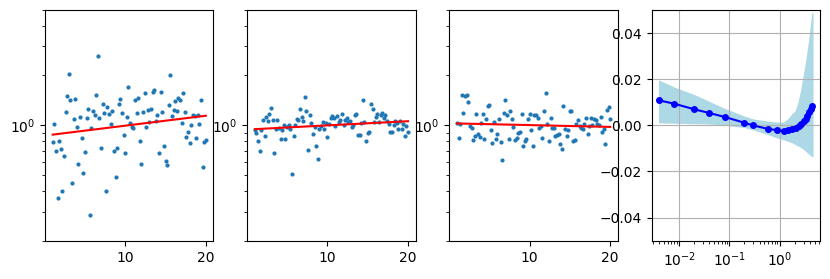

In [89]:
F = proc["su"][(5 * UNITS.s, "hann")]
dd = F.I_dists/F.pitch.to(UNITS.um).magnitude
print(F.fs,F.freq_max)
which_log_dd = [-2,-1,0]
which_idists = [argmin(abs(dd - 10**ddi)) for ddi in which_log_dd]
n_subplots = len(which_idists) + 1
figure(figsize=(10,3))
d_scale =  F.pitch.to(UNITS.um).magnitude    
for i, ddi in enumerate(which_idists):
    subplot(1,n_subplots,i+1)
    I = F.I[iprb][0]
    I_freqs = F.freqs[:I.shape[0]]
    ind_use = (I_freqs >= F.reg_freq_range[0]) & (I_freqs <= F.reg_freq_range[1])
    xx = I_freqs[ind_use].to(UNITS.Hz).magnitude
    yy = I[ind_use, ddi]
    xe = linspace(min(xx),max(xx),101)
    c0,c1 = F.reg_coefs[iprb][0][ddi]
    ye = 10**(c0 + c1 * xe)
    ym = 10**mean(log10(yy * d_scale**2))    
    semilogy(xx, (yy * d_scale**2)/ym, "o", markersize=2)
    semilogy(xe, (ye * d_scale**2)/ym, "r")
    ylim(0.2,5)



subplot(1,n_subplots, n_subplots)
pc = percentile(F.reg_coefs[iprb][1:][:,:,-1],[5,50,95],axis=0)
semilogx(dd, pc[1], "o-", color="blue", markersize=4)
fill_between(dd, pc[0], pc[2],color="lightblue")
ylim(-0.05,0.05)
grid(True)

### Plot window series

In [25]:
I = {}
fr = {}
for wnd_type in ["boxcar","hann"]:
    for ds in ["bw","su"]:
        k = sorted([k for k in proc[ds].keys() if k[1] == wnd_type])
        I[ds,wnd_type] = {ki:proc[ds][ki].I[0][0] for ki in k}
        fr[ds, wnd_type] = {ki:proc[ds][ki].freqs for ki in k}

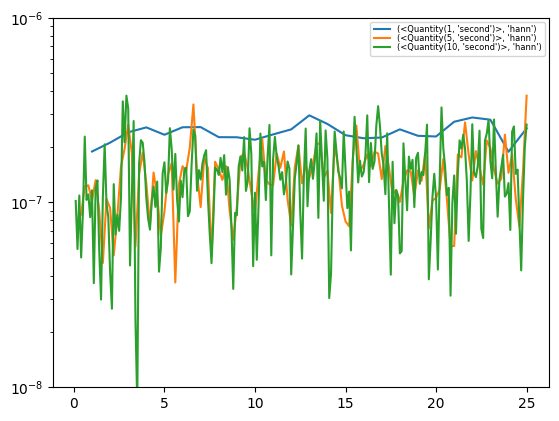

In [27]:
wnd_type = "hann"
ds = "su"
k = sorted([k for k in proc[ds].keys() if k[1] == wnd_type])    
for ki in k:
    Ii = I[ds, wnd_type][ki]
    fi = fr[ds, wnd_type][ki]
    xx = fi[1:Ii.shape[0]].to(UNITS.Hz).magnitude
    yy = log10(Ii[1:,1])
    semilogy(fi[1:Ii.shape[0]], Ii[1:,1], label = ki)
ylim(1e-8,1e-6)
legend(fontsize=6,labelspacing=0)    

# Plot window series

/nemo/lab/schaefera/working/tootoos/git/fisher-plumes/fisher_plumes_figs.py:652: RuntimeWarning: divide by zero encountered in log10
  im = ax.matshow(np.log10(I[ind_use]),


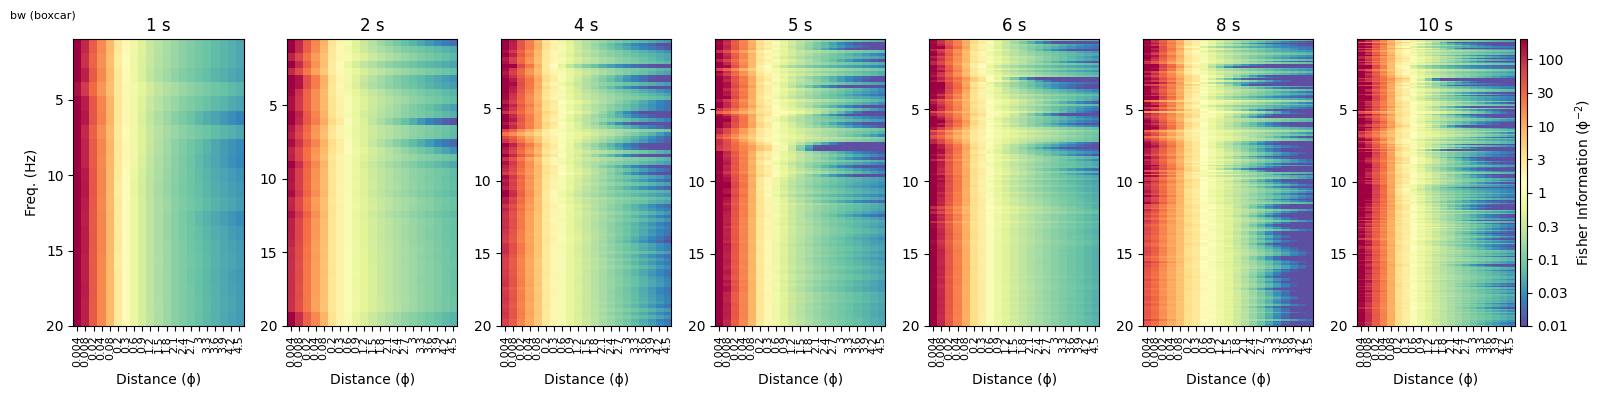

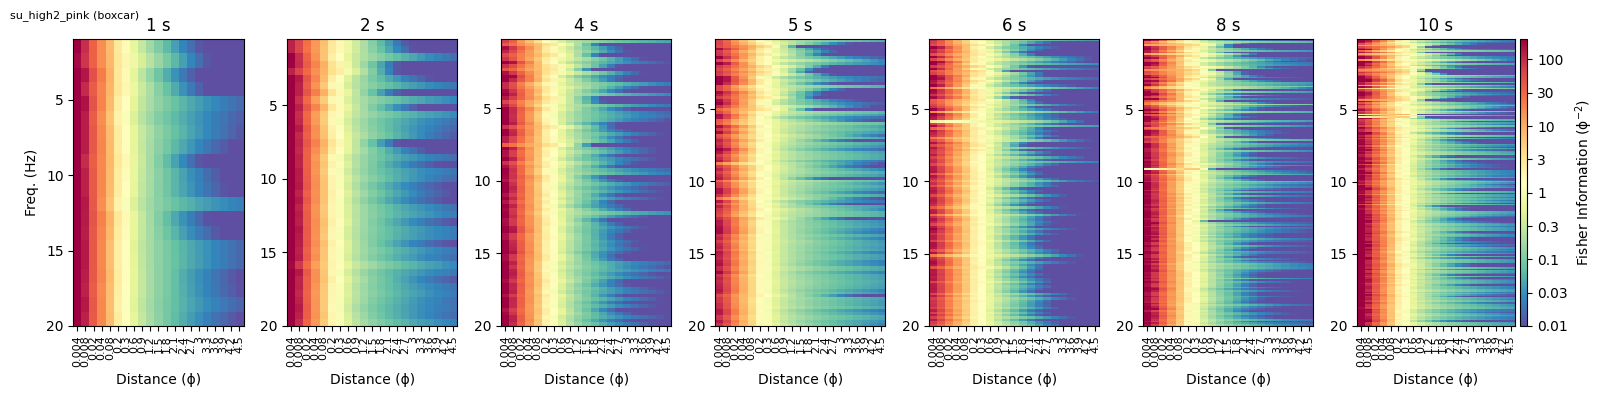

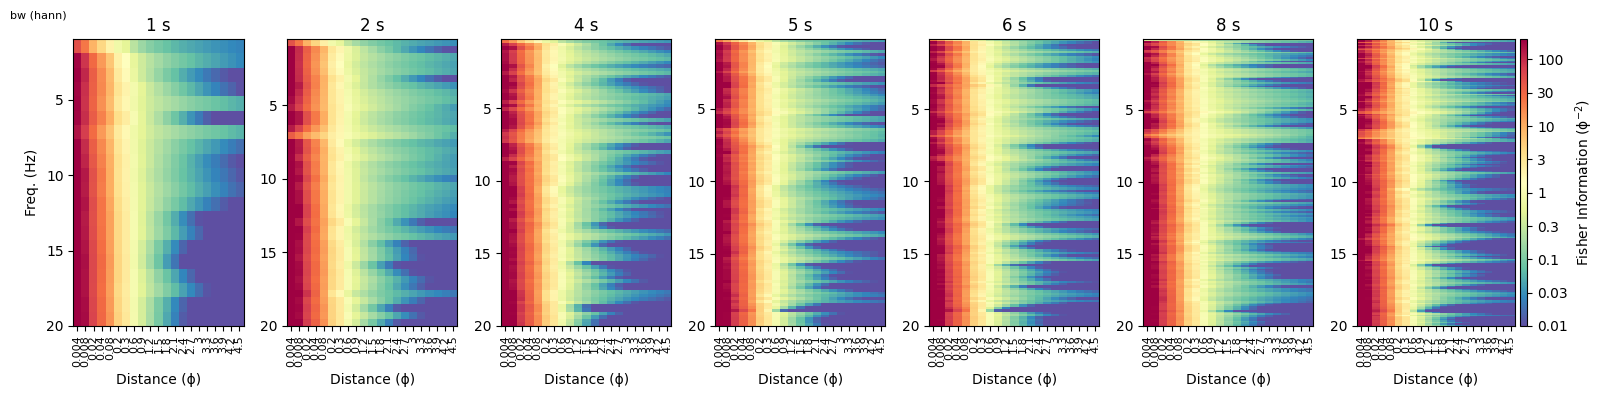

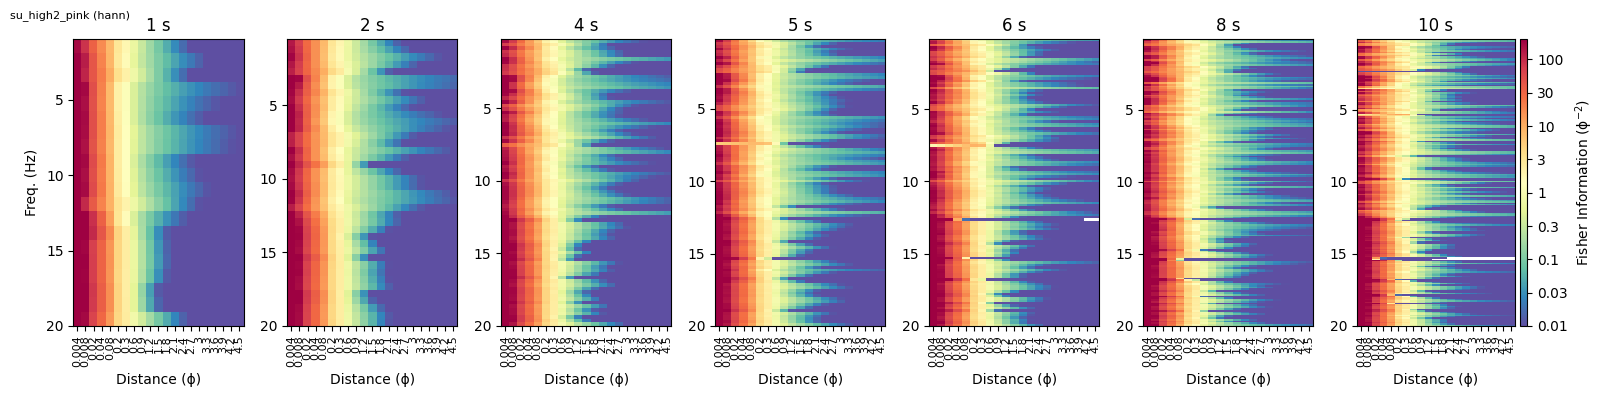

In [136]:
reload(fpf)
for wnd_type in ["boxcar","hann"]:
    for ds in ["bw","su_high2_pink"]:
        fpf.plot_window_series(proc[ds], wnd_type, heatmap_cm = cm.Spectral_r, heatmap_range = [-2, log10(200)], freq_max = 20 * UNITS.Hz, n_rows = 1, figsize = (16,4))
        suptitle(f"{ds} ({wnd_type})", x=0.0, horizontalalignment="left", fontsize=8)
    

### Set the time window of data that we want to plot

In [90]:
wnd2str = lambda wnd_t,wnd_sh: "_".join([
    f"wnd_{wnd_t.to(UNITS.s).magnitude:g}sec", f"{wnd_sh[0] if type(wnd_sh) is tuple else wnd_sh}"] + ([str(wnd_sh[1])] if type(wnd_sh) is tuple else []))

In [103]:
wnd_sec = 5 * UNITS.sec
wnd_shp = ('hann')
wnd_key = (wnd_sec, wnd_shp)
data_wnd = {k:v[wnd_key] for k,v in proc.items() if wnd_key in v and k != "su_high_pink"}
wnd_str = wnd2str(*wnd_key)
print(f"{len(data_wnd)} processed datasets found for {wnd_key=}\n{wnd_str=}")
print(list(data_wnd.keys()))

2 processed datasets found for wnd_key=(<Quantity(5, 'second')>, 'hann')
wnd_str='wnd_5sec_hann'
['bw', 'su']


### Whether to save the plots we make and where to put them

In [104]:
SAVEPLOTS = False # Whether to actually make the plots
fig_dir_fun = lambda wnd_str: f"figs/{wnd_str}"
fig_dir = fig_dir_fun(wnd_str)
if not os.path.exists(fig_dir):
    print(f"Creating {fig_dir=}")
    os.mkdir(fig_dir)
else:
    print(f"{fig_dir=} already exists.")

Creating fig_dir='figs/wnd_5sec_hann'


# Figure showing an example plume and correlations

In [105]:
DEFAULT   = "default"
isdefault = lambda x: type(x) is str and x == DEFAULT

su_ds = [k for k in data if k.startswith("su")]
print(f"Surrogate datasets = {su_ds}.")

which_srcs   = dict_update_from_field({"bw":[-3750, 3750],        "cr":[490000,510000]},        su_ds, "bw")        
t_wnd        = dict_update_from_field({"bw":[-4,4]*UNITS.sec,     "cr":[-0.5, 0.5]*UNITS.sec}, su_ds, "bw")
which_idists = dict_update_from_field({"bw":[0,2,3],              "cr":[0,10,20]},             su_ds, "bw")
tticks       = dict_update_from_field({"bw":DEFAULT,              "cr":[39.5,40,40.5]},        su_ds, "bw")
xticks       = dict_update_from_field({"bw":DEFAULT,              "cr":DEFAULT},               su_ds, "bw")
yticks       = dict_update_from_field({"bw":DEFAULT,              "cr":DEFAULT},               su_ds, "bw")

Surrogate datasets = ['su', 'su_high_white', 'su_high_pink'].


INFO:boulder:Loading fld='c1a' at t=40 from full_file='/camp/home/tootoos/working/tootoos/data/fisher-plumes/boulder/saved-snapshots/c1a_t40.p'.


INFO:boulder:Loading fld='c1b' at t=40 from full_file='/camp/home/tootoos/working/tootoos/data/fisher-plumes/boulder/saved-snapshots/c1b_t40.p'.


INFO:boulder:Loading fld='c2a' at t=40 from full_file='/camp/home/tootoos/working/tootoos/data/fisher-plumes/boulder/saved-snapshots/c2a_t40.p'.


INFO:boulder:Loading fld='c2b' at t=40 from full_file='/camp/home/tootoos/working/tootoos/data/fisher-plumes/boulder/saved-snapshots/c2b_t40.p'.


INFO:boulder:Loading fld='c3a' at t=40 from full_file='/camp/home/tootoos/working/tootoos/data/fisher-plumes/boulder/saved-snapshots/c3a_t40.p'.


INFO:boulder:Loading fld='c3b' at t=40 from full_file='/camp/home/tootoos/working/tootoos/data/fisher-plumes/boulder/saved-snapshots/c3b_t40.p'.


INFO:boulder:Loading fld='c4a' at t=40 from full_file='/camp/home/tootoos/working/tootoos/data/fisher-plumes/boulder/saved-snapshots/c4a_t40.p'.


INFO:boulder:Loading fld='c4b' at t=40 from full_file='/camp/home/tootoos/working/tootoos/data/fisher-plumes/boulder/saved-snapshots/c4b_t40.p'.


INFO:boulder:Loading fld='c5a' at t=40 from full_file='/camp/home/tootoos/working/tootoos/data/fisher-plumes/boulder/saved-snapshots/c5a_t40.p'.


INFO:boulder:Loading fld='c5b' at t=40 from full_file='/camp/home/tootoos/working/tootoos/data/fisher-plumes/boulder/saved-snapshots/c5b_t40.p'.


INFO:boulder:Loading fld='c6a' at t=40 from full_file='/camp/home/tootoos/working/tootoos/data/fisher-plumes/boulder/saved-snapshots/c6a_t40.p'.


INFO:boulder:Loading fld='c6b' at t=40 from full_file='/camp/home/tootoos/working/tootoos/data/fisher-plumes/boulder/saved-snapshots/c6b_t40.p'.


INFO:boulder:Loading fld='c7a' at t=40 from full_file='/camp/home/tootoos/working/tootoos/data/fisher-plumes/boulder/saved-snapshots/c7a_t40.p'.


INFO:boulder:Loading fld='c7b' at t=40 from full_file='/camp/home/tootoos/working/tootoos/data/fisher-plumes/boulder/saved-snapshots/c7b_t40.p'.


INFO:boulder:Loading fld='c8a' at t=40 from full_file='/camp/home/tootoos/working/tootoos/data/fisher-plumes/boulder/saved-snapshots/c8a_t40.p'.


INFO:boulder:Loading fld='c8b' at t=40 from full_file='/camp/home/tootoos/working/tootoos/data/fisher-plumes/boulder/saved-snapshots/c8b_t40.p'.


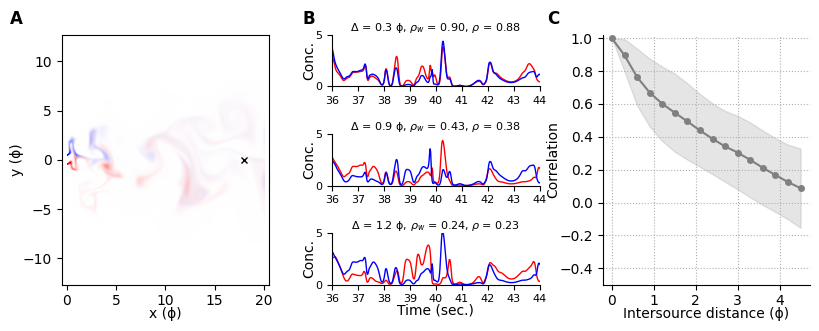

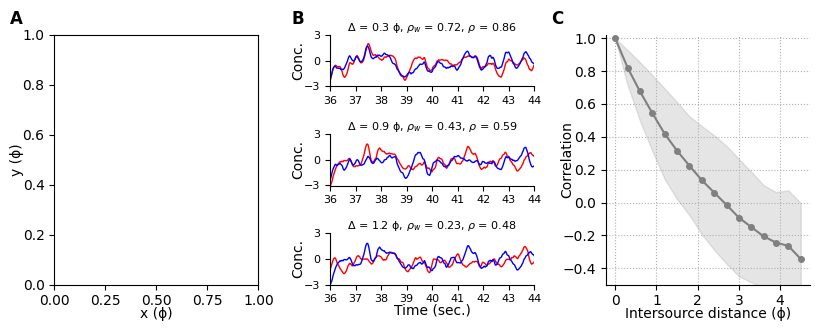

In [107]:
reload(fpf)
reload(fpft)

for k, F in sorted(data_wnd.items()):
    data_dir = os.path.join(os.environ["FISHER_PLUMES_DATA"], defaultdict(str, {"bw":"boulder", "cr":"crick"})[k], "saved-snapshots")
    ax_plume, ax_traces, ax_corr = fpf.plot_plumes_demo(F, 40 * UNITS.sec, which_srcs[k], y_lim = (0,5.01) if k[:2]!="su" else (-3.01,3.01), y_ticks = [-3,0,3] if k[:2]=="su" else None,
                                                        t_wnd = t_wnd[k], dt = 1 * UNITS.sec, which_idists=which_idists[k], data_dir=data_dir)
    not isdefault(tticks[k]) and ax_traces[-1].set_xticks(tticks[k])    
    not isdefault(xticks[k]) and ax_plume.set_xticks(xticks[k])
    not isdefault(yticks[k]) and ax_plume.set_yticks(yticks[k])
    if k in ["su_high", "su", "bw"]: ax_corr.set_xticks(arange(5))
    if k.startswith("su"): [ax_corr.set_ylim(-0.85,1.05), ax_corr.set_ylabel("Correlation",labelpad=-8)]
    fpft.label_axes([ax_plume, ax_traces[0], ax_corr], "ABC", y = [0.99]*3, fontsize=12, fontweight="bold")
    file_name = f"{fig_dir}/plumes_demo_{k}.pdf"
    ax_corr.set_ylim(-0.5,1.02)
    SAVEPLOTS and (savefig(file_name, bbox_inches='tight'), flush(f"Wrote {file_name}."));
    sys.stdout.flush(); plt.show()

# Set the probe index we'll use

In [108]:
iprb = 0

# Figure showing the distribution of correlations

bw
Mapped frequencies [ 1  3 17 20] Hz to indices [5, 15, 85, 100].


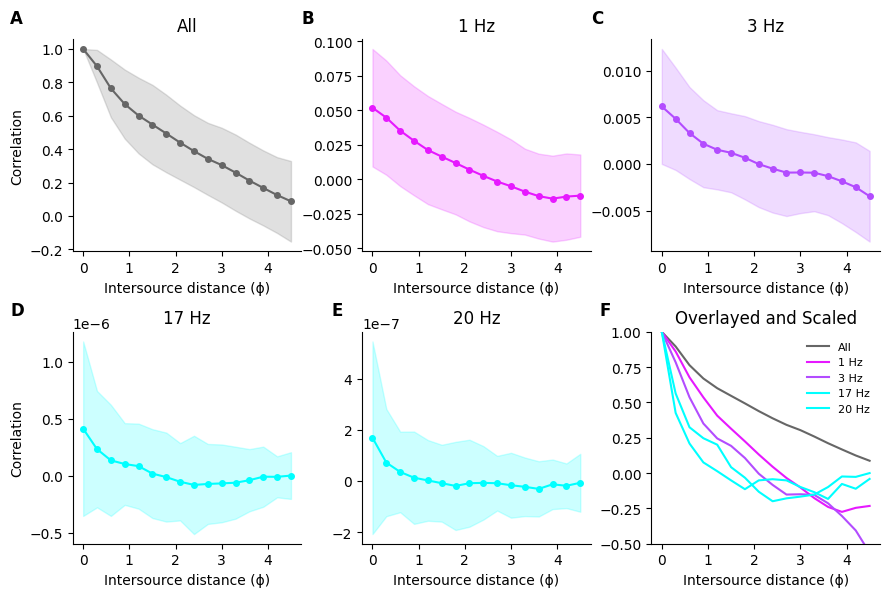

su
Mapped frequencies [ 1  3 17 20] Hz to indices [5, 15, 85, 100].


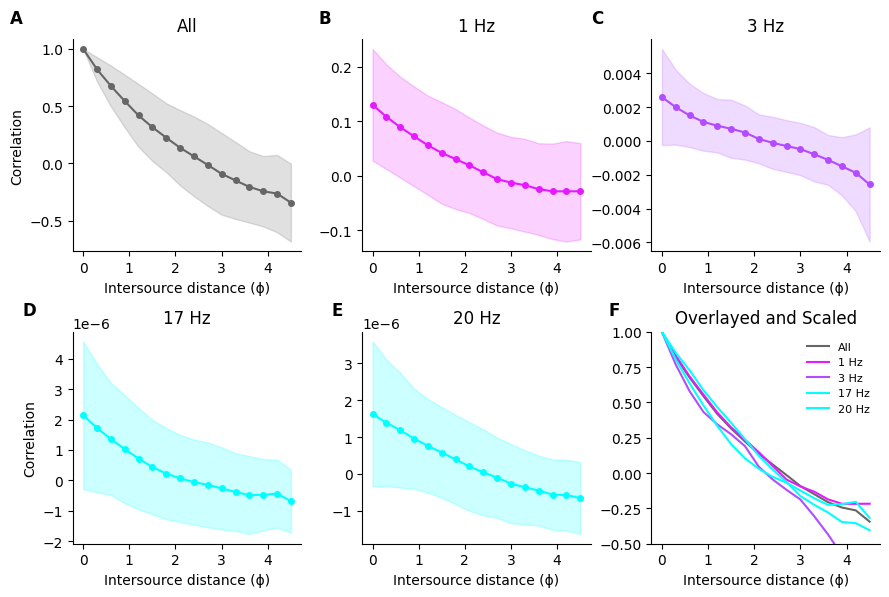

In [109]:
reload(fpf)
xlims_  = defaultdict(lambda: DEFAULT) #{"su_high":DEFAULT, "su":DEFAULT, "bw":DEFAULT, "cr":DEFAULT}
xticks_ = defaultdict(lambda: DEFAULT) #{"su_high":DEFAULT, "su":DEFAULT, "bw":DEFAULT, "cr":DEFAULT}
for k, F in data_wnd.items():
    which_freqs = ([1,3,17,20] if k.startswith("su_high") else [1,3,17,20]) * UNITS.Hz
    labs = [f"{f}" for f in which_freqs]
    cols = {"All":cm.gray(0.4)}; cols.update({l:col for l,col in zip(labs, [cm.cool(1 - f.magnitude/10) for f in which_freqs])})    
    print(k)
    slices = {"All":slice(1,10000)}
    freq_inds = F.freqs2inds(which_freqs)
    print(f"Mapped frequencies {which_freqs} to indices {freq_inds}.")
    slices.update({l:slice(fi, fi+1) for l, fi in zip(labs, freq_inds)})
    ax = fpf.plot_correlations(F.rho[iprb], F.pitch.to("um").magnitude, slices=slices, cols=cols, n_rows = 2, plot_order = ["All"] + labs)
    [(axi.set_xlabel(f"Intersource distance ({fpf.pitch_sym})"),
      not isdefault(xlims_[k])  and axi.set_xlim(xlims_[k]),
      not isdefault(xticks_[k]) and axi.set_xticks(xticks_[k])) for axi in ax]    
    file_name = f"{fig_dir}/corr_components_{k}.pdf"
    fpft.label_axes(ax, "ABCDEF", fontsize=12, fontweight="bold", dy=-0.01)
    ax[-1].set_ylim(-0.5,1)
    SAVEPLOTS and (savefig(file_name, bbox_inches='tight'), flush(f"Wrote {file_name}."))
    sys.stdout.flush(); plt.show()

# The Multivariate Gaussian Fits

bw
Mapped 5 Hz to index 25.


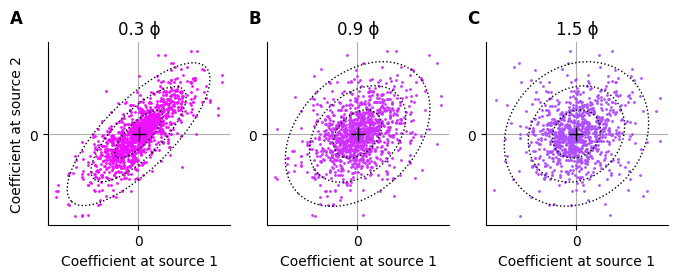

su
Mapped 5 Hz to index 25.


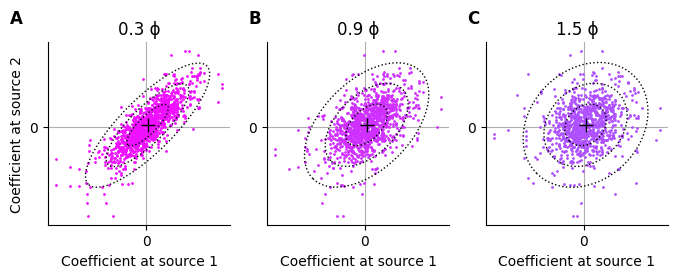

In [110]:
reload(fpf)
which_freqs = dict_update_from_field({"bw":5 * UNITS.hertz, "cr":5 * UNITS.hertz}, su_ds, "bw")
which_idists= dict_update_from_field({"bw":[0,2,4],         "cr":[8,12,18]},       su_ds, "bw")
dcol_scales = dict_update_from_field({"bw":120000,          "cr":80000},           su_ds, "bw")
for name, F in sorted(data_wnd.items()):
    print(name)
    which_freq = which_freqs[name]
    ifreq = F.freqs2inds([which_freq])[0]
    print(f"Mapped {which_freq} to index {ifreq}.")
    ax = fpf.plot_coef1_vs_coef2([F.ss[iprb], F.cc[iprb]],
                                 ifreq,
                                 F.pairs_um,
                                 F.pitch_string,                                 
                            i_pos_dists_to_plot = which_idists[name],
                            dist_col_scale = dcol_scales[name]
    )
    fpft.label_axes(ax, "ABC", fontsize=12, fontweight="bold", dy=-0.01)            
    file_name = f"{fig_dir}/coef_vs_coef_{name}_{which_freq.magnitude}Hz.pdf"
    SAVEPLOTS and (savefig(file_name, bbox_inches='tight'), flush(f"Wrote {file_name}."));
    sys.stdout.flush(); plt.show()

# Supplementary Information

<Figure size 800x300 with 0 Axes>

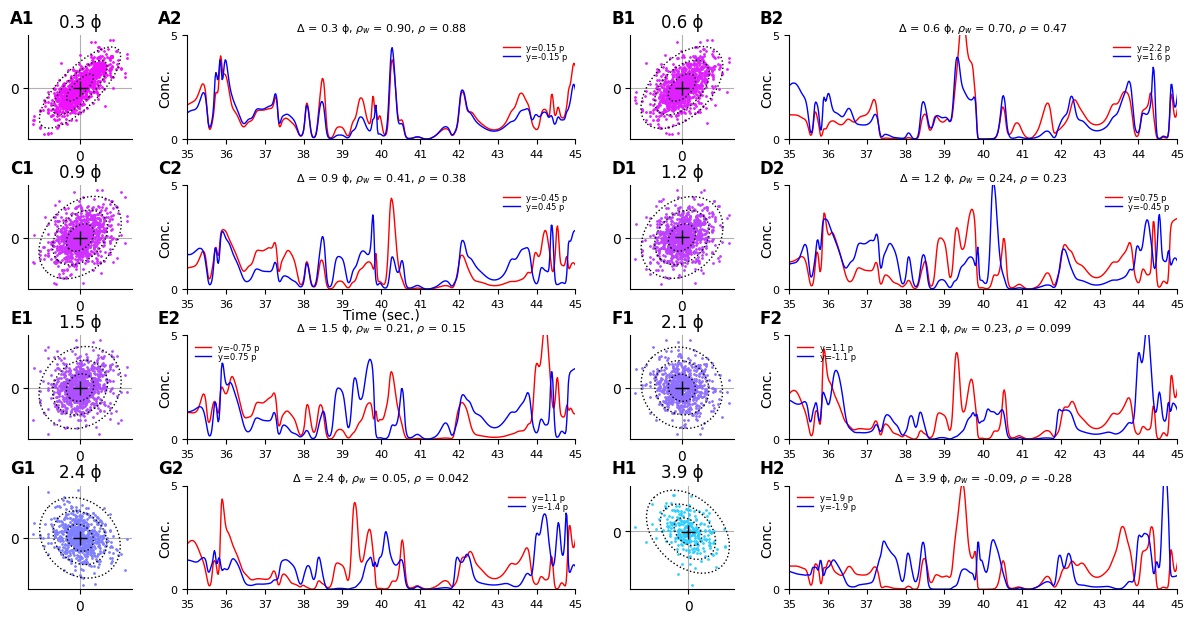

<Figure size 800x300 with 0 Axes>

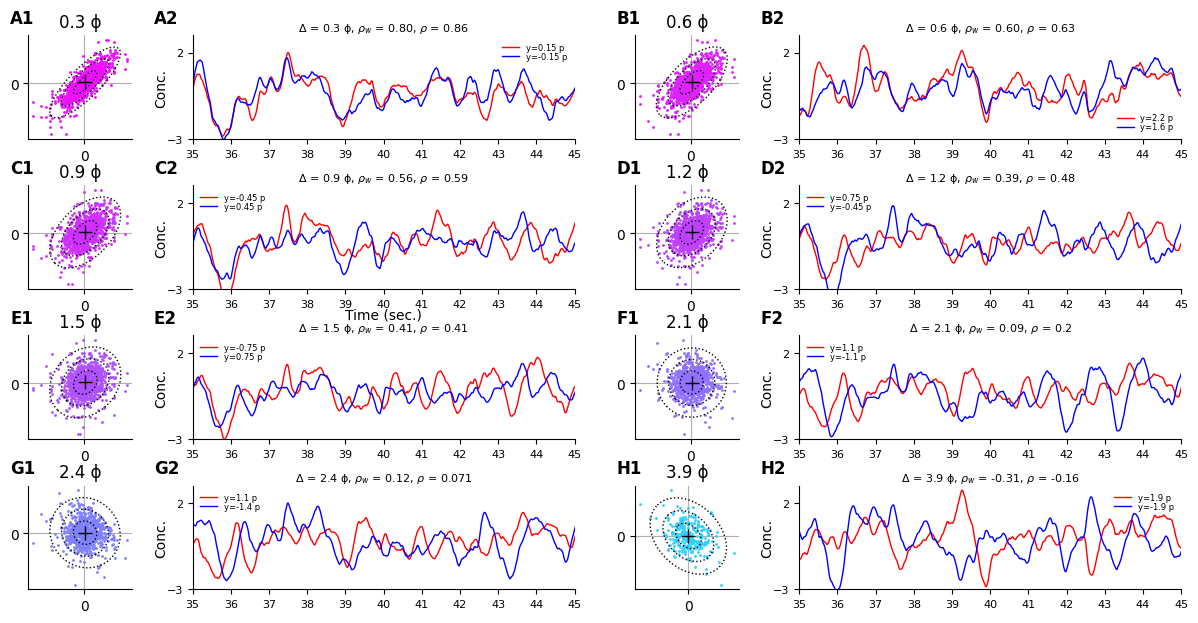

In [111]:
reload(fpf)
reload(fpft)
freq      = dict_update_from_field({"bw":5 * UNITS.hertz,          "cr":5 * UNITS.hertz},        su_ds, "bw")
idists    = dict_update_from_field({"bw":[0,1,2,3,4,6,7,12],       "cr":[0,4,8,12,16,20,21,22]}, su_ds, "bw")
t_lim     = dict_update_from_field({"bw":[35, 45]*UNITS.sec,       "cr":[39.5,40.5]*UNITS.sec},  su_ds, "bw")
dt        = dict_update_from_field({"bw":1*UNITS.sec,              "cr":0.25*UNITS.sec},         su_ds, "bw")
for k, F in sorted(data_wnd.items()):
    figure(figsize=(12,6))
    coef_ax, trace_ax = fpf.plot_coef_vs_coef_and_traces(F, freq[k], idists[k],
                                                         which_probe = iprb, n_per_row = 2,
                                                         y_lim=[0,5] if k[:2]!="su" else [-3,3],
                                                         t_lim = t_lim[k],
                                                         dt = dt[k])
    for ax in coef_ax:
        ax.set_xlabel("")
        ax.set_ylabel("")
    [ax.legend(fontsize=6,labelspacing=0,frameon=False) for ax in trace_ax]
    tight_layout(pad=0)
    all_ax = bsum([[ax_c, ax_t] for ax_c, ax_t in zip(coef_ax, trace_ax)], [])
    n_ax   = len(all_ax)
    fpft.label_axes(all_ax,
                    [ch+nu for ch in "ABCDEFGH" for nu in "12"],
                    align_x = [list(range(i,n_ax,4)) for i in range(4)],
                    align_y = [list(range(i,i+4)) for i in range(0,n_ax,4)],
                    fontsize=12, fontweight="bold", dy=-0.01)
    file_name = f"{fig_dir}/coefs_and_traces_{k}_{freq[k].to(UNITS.hertz).magnitude}Hz.pdf"
    SAVEPLOTS and (savefig(file_name, bbox_inches='tight'), flush(f"Wrote {file_name}."));
    sys.stdout.flush(); plt.show()

# Asymmetric Laplacian Fits

      fisher_plumes_figs 2023/05/20 10:22:37     INFO: d=7500 @ Freq #   5: -np.log10(p) = 3.137


      fisher_plumes_figs 2023/05/20 10:22:37     INFO: d=15000 @ Freq #   5: -np.log10(p) = 2.909


      fisher_plumes_figs 2023/05/20 10:22:37     INFO: d=22500 @ Freq #   5: -np.log10(p) = 2.440


bw
Setting extent to [-0.5, 15.5, 0.1, 20.9].


/camp/home/tootoos/working/tootoos/conda-envs/py38/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1369: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return np.asarray(x, float)


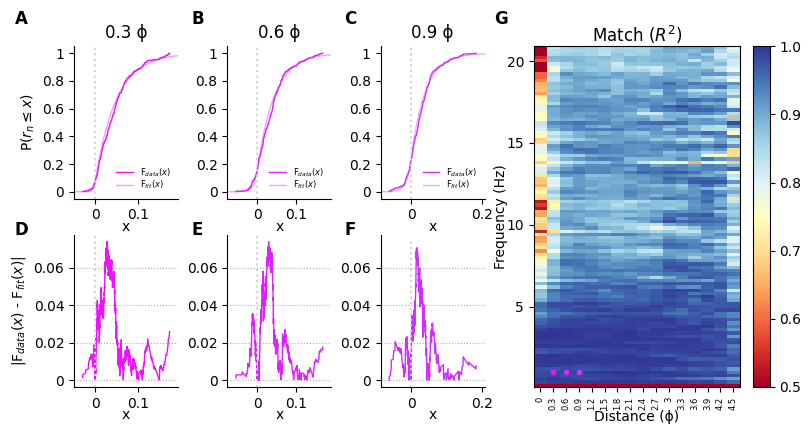

      fisher_plumes_figs 2023/05/20 10:22:38     INFO: d=7500 @ Freq #  25: -np.log10(p) = 3.553


      fisher_plumes_figs 2023/05/20 10:22:38     INFO: d=15000 @ Freq #  25: -np.log10(p) = 3.176


      fisher_plumes_figs 2023/05/20 10:22:38     INFO: d=22500 @ Freq #  25: -np.log10(p) = 3.696


Setting extent to [-0.5, 15.5, 0.1, 20.9].


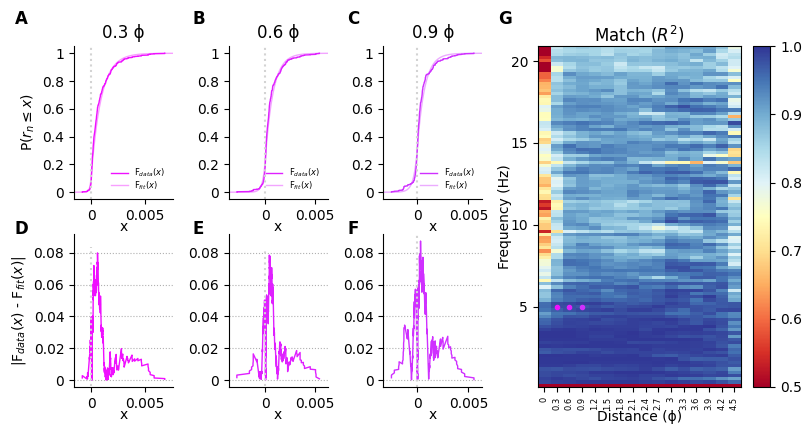

      fisher_plumes_figs 2023/05/20 10:22:39     INFO: d=7500 @ Freq #  50: -np.log10(p) = 23.973


      fisher_plumes_figs 2023/05/20 10:22:39     INFO: d=15000 @ Freq #  50: -np.log10(p) = 9.027


      fisher_plumes_figs 2023/05/20 10:22:39     INFO: d=22500 @ Freq #  50: -np.log10(p) = 8.520


Setting extent to [-0.5, 15.5, 0.1, 20.9].


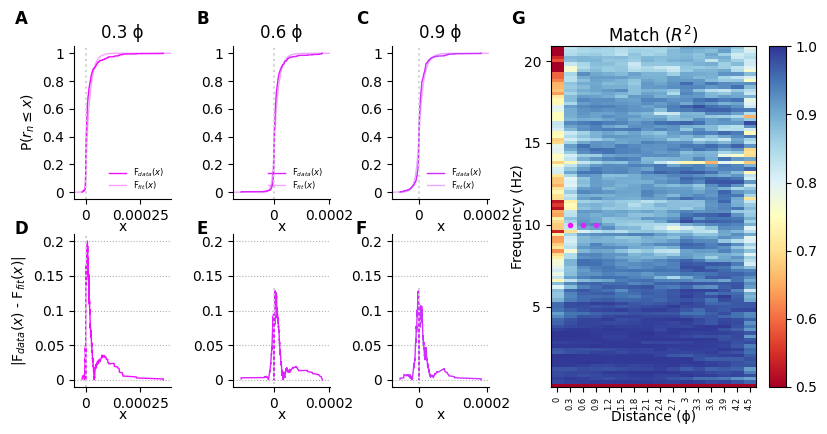

      fisher_plumes_figs 2023/05/20 10:22:40     INFO: d=7500 @ Freq #   5: -np.log10(p) = 5.124


      fisher_plumes_figs 2023/05/20 10:22:40     INFO: d=15000 @ Freq #   5: -np.log10(p) = 3.063


      fisher_plumes_figs 2023/05/20 10:22:40     INFO: d=22500 @ Freq #   5: -np.log10(p) = 2.840


su


Setting extent to [-0.5, 15.5, 0.1, 20.9].


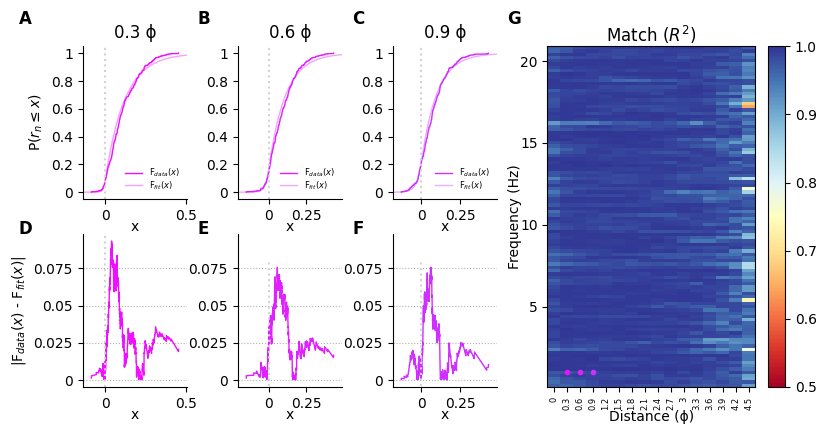

      fisher_plumes_figs 2023/05/20 10:22:41     INFO: d=7500 @ Freq #  25: -np.log10(p) = 1.862


      fisher_plumes_figs 2023/05/20 10:22:41     INFO: d=15000 @ Freq #  25: -np.log10(p) = 0.673


      fisher_plumes_figs 2023/05/20 10:22:41     INFO: d=22500 @ Freq #  25: -np.log10(p) = 0.281


Setting extent to [-0.5, 15.5, 0.1, 20.9].


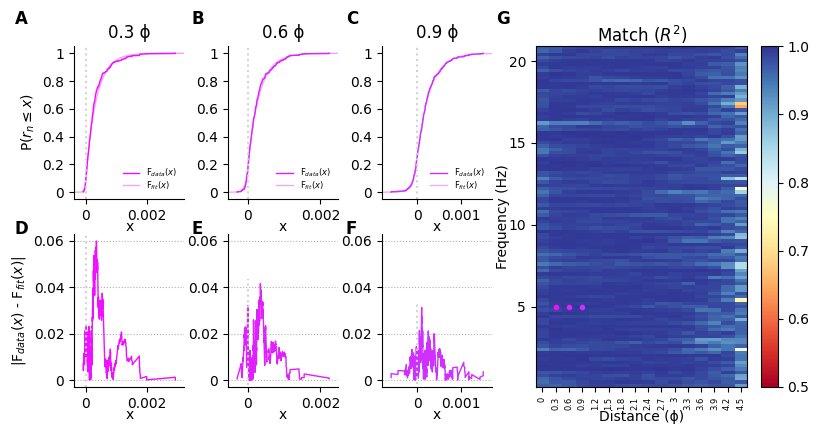

      fisher_plumes_figs 2023/05/20 10:22:41     INFO: d=7500 @ Freq #  50: -np.log10(p) = 2.272


      fisher_plumes_figs 2023/05/20 10:22:42     INFO: d=15000 @ Freq #  50: -np.log10(p) = 1.593


      fisher_plumes_figs 2023/05/20 10:22:42     INFO: d=22500 @ Freq #  50: -np.log10(p) = 2.249


Setting extent to [-0.5, 15.5, 0.1, 20.9].


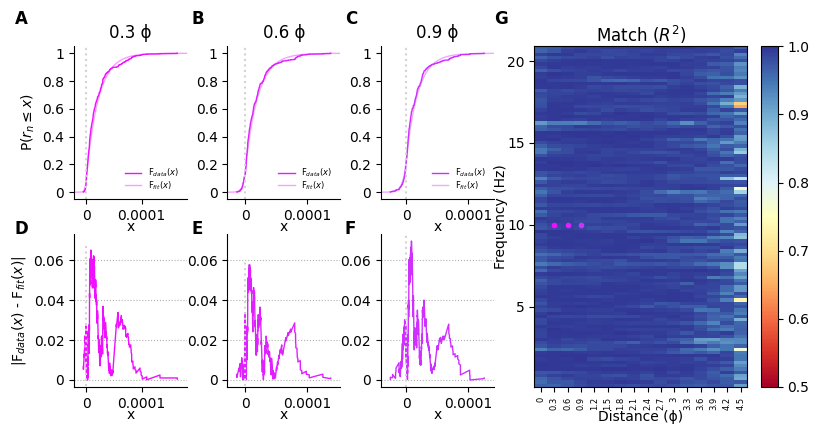

In [112]:
reload(fpft)
reload(fpf)
which_wnd_sec = wnd_sec_vals[0]
idist     = dict_update_from_field({"bw":[1,2,3],          "cr":[1,13,19]},         su_ds, "bw")
freq_max  = dict_update_from_field({"bw":21 * UNITS.hertz, "cr":101 * UNITS.hertz}, su_ds, "bw")
vmin      = dict_update_from_field({"bw":[0,0.5],          "cr":[0,0.5]},           su_ds, "bw")
vmax      = dict_update_from_field({"bw":[50,1],           "cr":[10,1]},            su_ds, "bw")
plot_pvals= False
for name, F in sorted(data_wnd.items()):
    if name == "bw1": continue
    print(name)
    d = np.array(list(F.rho[iprb].keys()))
    d = np.sort(d[d>=0])
    for f in [1, 5, 10] * UNITS.hertz:
        which_freq = defaultdict(lambda: f)
        ax_cdf, ax_dcdf, ax_hm = fpf.plot_alaplace_fits(F, d[idist[name]],
                                                        which_probe = iprb,
                               ifreq_lim = [1, F.freqs2inds([freq_max[name]])[0]],
                               which_ifreq = F.freqs2inds([which_freq[name]])[0],
                                                        figsize=(8,4),
                                                        vmax=vmax[name],
                                                        vmin=vmin[name],
                                                        plot_dvals=True,
                                                        plot_pvals=plot_pvals)
        tight_layout(pad=0)
        fpft.label_axes(ax_cdf + ax_dcdf + ax_hm, "ABCDEFGHIJK",
                        align_y = [[0,1,2,6],[3,4,5,7]] if plot_pvals else [[0,1,2],[3,4,5]],
                        align_x = [[0,3],[1,4],[2,5]],
                        fontsize=12, fontweight="bold", dy=0)
        file_name = f"{fig_dir}/alap_fits_{name}_{which_freq[name].to(UNITS.hertz).magnitude}Hz.pdf"
        SAVEPLOTS and (savefig(file_name, bbox_inches='tight'), flush(f"Wrote {file_name}."));
        sys.stdout.flush(); plt.show()

# Plot the figure showing λ(s)

/camp/home/tootoos/working/tootoos/conda-envs/py38/lib/python3.8/site-packages/matplotlib/colors.py:710: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  xa = np.array(X, copy=True)
      fisher_plumes_figs 2023/05/20 10:44:24     INFO: plot_gen_exp_paramter_fits_panel with which_fis=[5, 15, 85, 95], log_scale=True.


bw


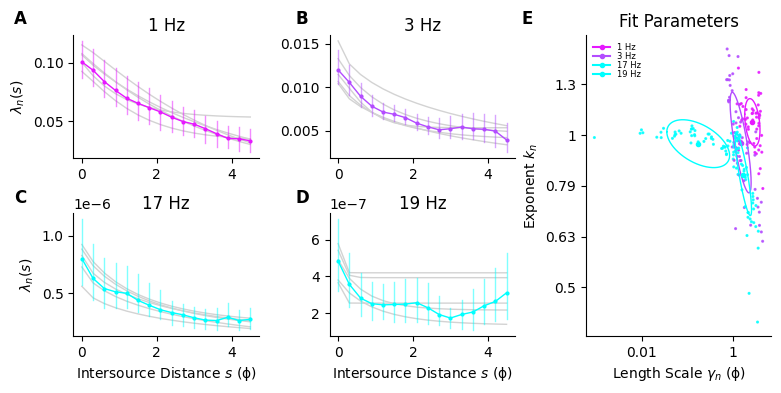

      fisher_plumes_figs 2023/05/20 10:44:25     INFO: plot_gen_exp_paramter_fits_panel with which_fis=[5, 15, 85, 95], log_scale=True.


su


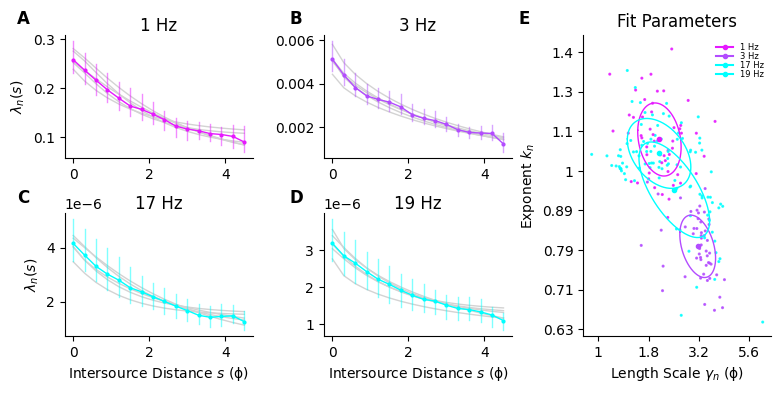

In [119]:
reload(fpft)
reload(fpf)
freqs  = dict_update({fld:[1,3,17,19] * UNITS.hertz for fld in ["bw", "cr", "su"]}, ["su_high_white", "su_high_pink", "su_high2_pink", "su_white"], [[1,3,17,20] * UNITS.hertz]*4)
xl     = dict_update_from_field({"bw":(-10,200),                 "cr": (-2, 50)},                    su_ds, "bw")
xt     = dict_update_from_field({"bw":arange(0,201,50),          "cr": arange(0,101,25)},            su_ds, "bw")
xtp    = dict_update_from_field({"bw":np.array([60,90,135]),     "cr": np.array([40,60, 90, 135])},  su_ds, "bw")
ytp    = dict_update_from_field({"bw":np.array([0.8,1,1.2,1.5]), "cr": np.array([0.8,1,1.2,1.5,2])}, su_ds, "bw")
for k, F in sorted(data_wnd.items()):
    print(k)
    ax = fpf.plot_la_gen_fits_vs_distance(F, 
                                          figsize=(8,4), legloc = 'right',
                                          log_scale = True,
                                          scatter_size=1.5,
                                          which_ifreqs = F.freqs2inds(freqs[k]))
    [((i>1) and axi.set_xlabel(f"Intersource Distance $s$ ({fpf.pitch_sym})")) for i, axi in enumerate(ax[:4])]
    tight_layout(h_pad=1,w_pad=0.5)
    fpft.label_axes(ax, "ABCDEFGHIJK",
                    align_y = [[0,1,4],[2,3]],
                    align_x = [[0,2],[1,3]],
                    fontsize=12, fontweight="bold", dy=-0.02)                        
    file_name = f"{fig_dir}/la_vs_s_fits_{k}.pdf"
    SAVEPLOTS and (savefig(file_name, bbox_inches='tight'), flush(f"Wrote {file_name}."));
    sys.stdout.flush(); plt.show()

# Plot the 

# Plot the Fisher Information

      fisher_plumes_figs 2023/05/20 10:24:04     INFO: dd[0]=100, dd[-1]=125000 (0.004, 5 ϕ)


bw


      fisher_plumes_figs 2023/05/20 10:24:05     INFO: Plotting which_ifreqs=[5, 10, 25, 50, 100].


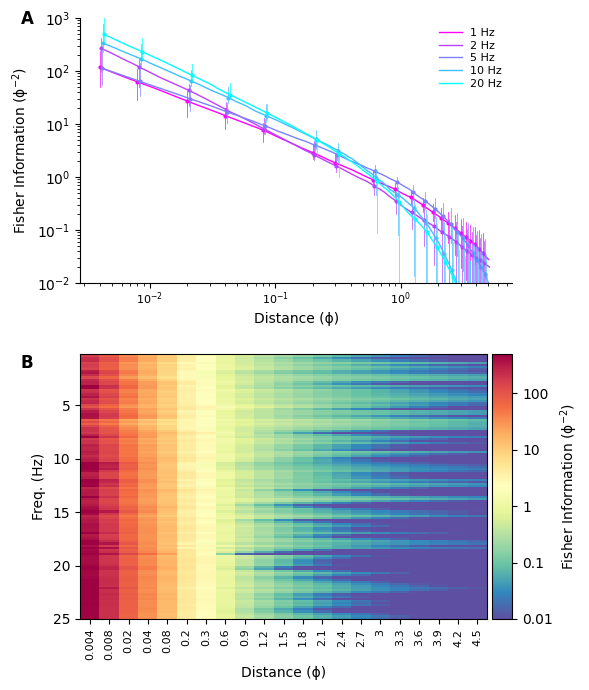

      fisher_plumes_figs 2023/05/20 10:24:06     INFO: dd[0]=100, dd[-1]=125000 (0.004, 5 ϕ)


su


      fisher_plumes_figs 2023/05/20 10:24:06     INFO: Plotting which_ifreqs=[5, 10, 25, 50, 100].


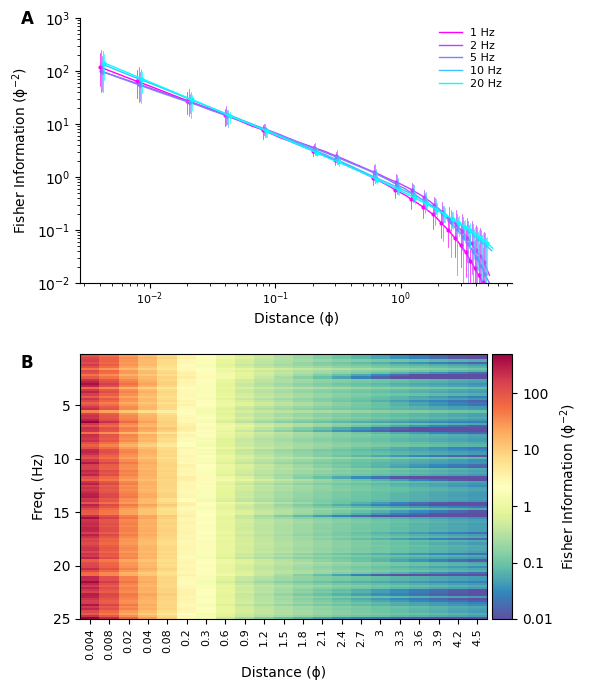

In [116]:
reload(fpt)
reload(fpft)
reload(fpf)
freqs     = dict_update_from_field({"cr":[5,10,20,50,100] * UNITS.hertz, "bw":[1,2, 5, 10, 20] * UNITS.hertz}, su_ds, "bw")
freq_max  = dict_update_from_field({"bw":25 * UNITS.hertz, "cr":100 * UNITS.hertz}, su_ds, "bw")
colscale  = dict_update_from_field({"bw":10,               "cr":40},                su_ds, "bw")
d_vals_um = dict_update_from_field({"bw":[1,5,50],         "cr":[0.1,10,70]},       su_ds, "bw")
d_lim_um  = dict_update_from_field({"bw":[100, 125000 ],   "cr":[100, 125000]},     su_ds, "bw")
bf_ytick  = dict_update_from_field({"bw":[0,5,10],         "cr":[0,50,100]},        su_ds, "bw")
bf_yl     = dict_update_from_field({"bw":[0,15],           "cr":[-5,100]},          su_ds, "bw")
plot_param_fits = False
for k, F in sorted(data_wnd.items()):
    print(k)
    figure(figsize=(6,7))
    ax_fisher, ax_best_freq, ax_d = fpf.plot_fisher_information(F,
                                                                which_probe = iprb,
                                                                d_lim_um   = d_lim_um[k],
                                                                d_vals_um  = np.array(d_vals_um[k])*1000,
                                                                d_space_fun  = lambda d0,d1,n:np.logspace(log10(d0),log10(d1),n),
                                                                which_ifreqs = F.freqs2inds(freqs[k]),
                                                                x_stagger = lambda x, i: x*(1.02**i),
                                                                plot_fun = plt.loglog,
                                                                log_scale = True,
                                                                plot_param_fits = plot_param_fits,
                                                                freq_max  = freq_max[k],
                                                                colfun    = lambda f: cm.cool_r(f/colscale[k]),
                                                                info_heatmap = True,
                                                                heatmap_range =[-2, log10(500)],
                                                                heatmap_cm    =cm.Spectral_r,
                                                                #bf_ytick  = bf_ytick[k],
    )
    ax_fisher.set_ylim(1e-2,1e3)
    tight_layout(h_pad=2,w_pad=0)
    fpft.label_axes([ax_fisher, ax_best_freq] + ax_d , "ABCDEFGHIJK",
                    #align_y = [[2,3,4]],
                    align_x = [[0,1,2] if plot_param_fits else [0,1]],
                    fontsize=12, fontweight="bold", dy=-0.02)
    #ax_best_freq.set_ylim(bf_yl[k])
    file_name = f"{fig_dir}/fisher_info_{k}.pdf"
    SAVEPLOTS and (savefig(file_name, bbox_inches='tight'), flush(f"Wrote {file_name}."));
    sys.stdout.flush(); plt.show()
    

# Plot Fisher information heatmaps together

Wrote figs/fisher_info_heatmaps.pdf.


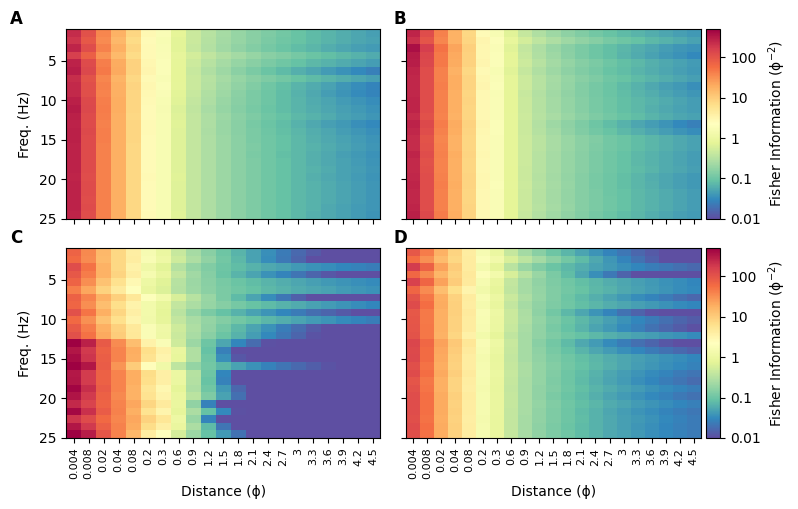

In [218]:
figure(figsize=(8,5))
gs = GridSpec(2,2)
order = ["bw", "su", "su_high_white", "su_high_pink"]
which_wnd = (1 * UNITS.s, 'boxcar')
axes, cbs = [], []
for o, gsi in zip(order, gs):
    axes.append(subplot(gsi))
    axes[-1], cbi = fpf.plot_fisher_information_heatmap(proc[o][which_wnd], 0, ax = axes[-1], freq_max = freq_max[o],
                                                        heatmap_range =[-2, log10(500)],
                                                        heatmap_cm    =cm.Spectral_r,
                                                        do_colorbar   = gsi.is_last_col(),
    )
    if gsi.is_first_row():
        axes[-1].tick_params(labelbottom=False)
        axes[-1].set_xlabel("")

    if not gsi.is_first_col():
        axes[-1].tick_params(labelleft = False)
        axes[-1].set_ylabel("")
tight_layout(w_pad = 1.5, h_pad=1.5)
fpft.label_axes(axes, "ABCD",
                align_y = [[0,1],[2,3]],
                align_x = [[0,2],[1,3]],
                fontsize=12, fontweight="bold", dy=0.01, dx = -0.01)
file_name = f"figs/fisher_info_heatmaps.pdf"
SAVEPLOTS and (savefig(file_name, bbox_inches='tight', pad_inches=0), flush(f"Wrote {file_name}."));
sys.stdout.flush(); plt.show()
        

# Main figure showing effect of windowing

Wrote figs/effect_of_windowing.pdf.


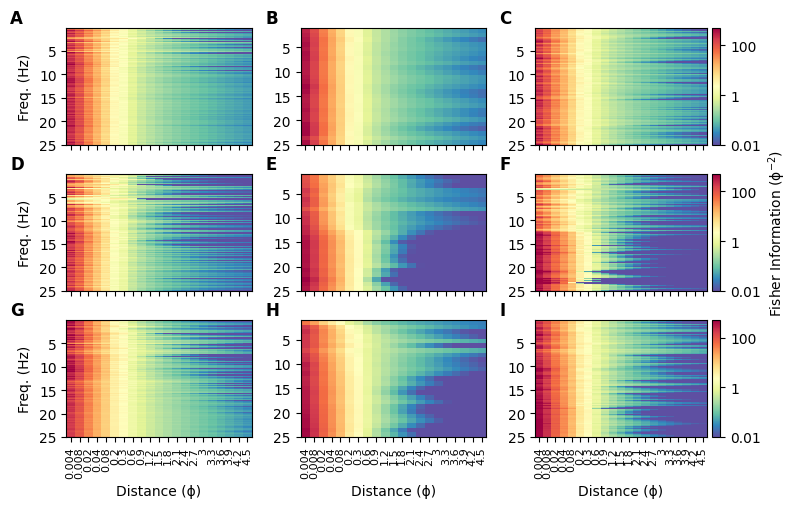

In [215]:
reload(fpf)
figure(figsize=(8,5))
col_keys = [(10 * UNITS.s, 'boxcar'), (1 * UNITS.s, 'hann'), (5 * UNITS.s, 'hann')]
heatmap_range = defaultdict(lambda: [-2, log10(500)], {"bw":[-2,log10(500)], "su_high2_pink":[-2,log10(500)]})
row_ds   = ["su", "su_high_pink", "bw"]
gs       = GridSpec(len(row_ds), len(col_keys))
ax       = []
for i, ds in enumerate(row_ds):
    for j, ck in enumerate(col_keys):
        ax.append(subplot(gs[i,j]))
        p = proc[ds][ck]
        _, cb = fpf.plot_fisher_information_heatmap(
            p, 0, ax = ax[-1], heatmap_range = heatmap_range[ds],
            do_colorbar = gs[i,j].is_last_col(),
        )
        if gs[i,j].is_last_col() and i!=1: cb.ax.set_ylabel("")
        if not gs[i,j].is_first_col(): ax[-1].set_ylabel("")
        if not gs[i,j].is_last_row():  [ax[-1].set_xlabel(""),ax[-1].set_xticklabels([])]
tight_layout(w_pad = 1.5, h_pad=1.5)
fpft.label_axes(ax, "ABCDEFGHI",
                align_y = [[0,1,2],[3,4,5],[6,7,8]],
                align_x = [[0,3,6],[1,4,7],[2,5,8]],
                fontsize=12, fontweight="bold", dy=0.01, dx = -0.01)
file_name = f"figs/effect_of_windowing.pdf"
SAVEPLOTS and (savefig(file_name, bbox_inches='tight', pad_inches=0), flush(f"Wrote {file_name}."));
sys.stdout.flush(); plt.show()
        


# Information heatmaps as window size is changed

Wrote figs/bw_boxcar_series.pdf.


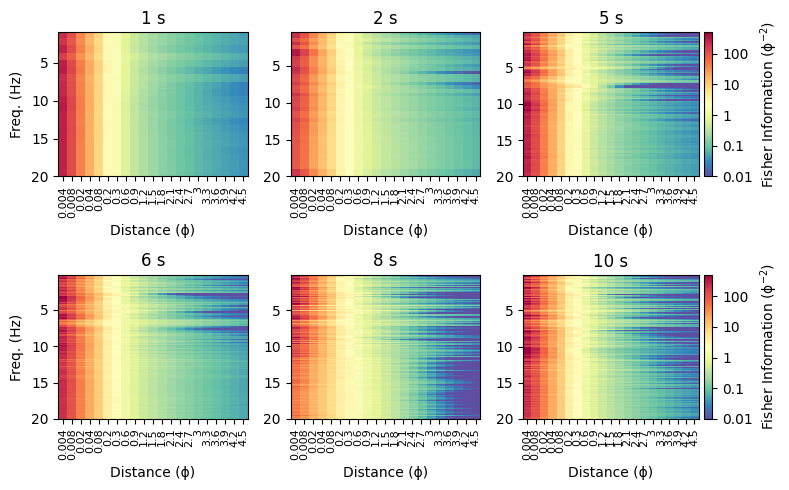

Wrote figs/bw_hann_series.pdf.


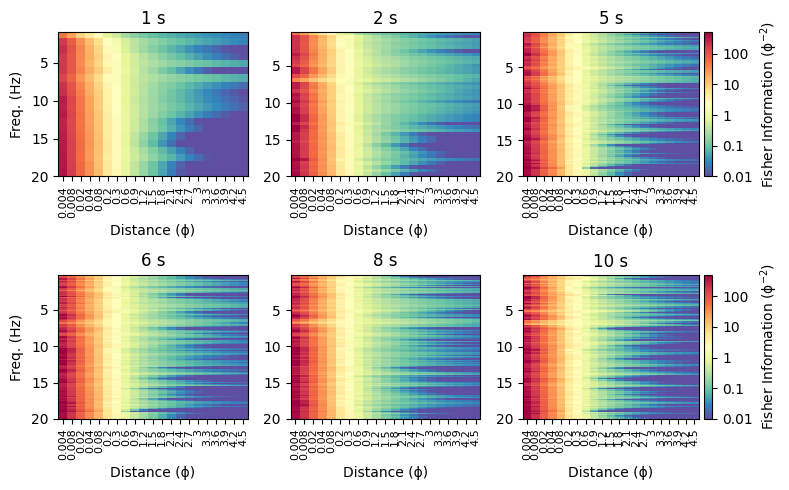

Wrote figs/su_high_pink_boxcar_series.pdf.


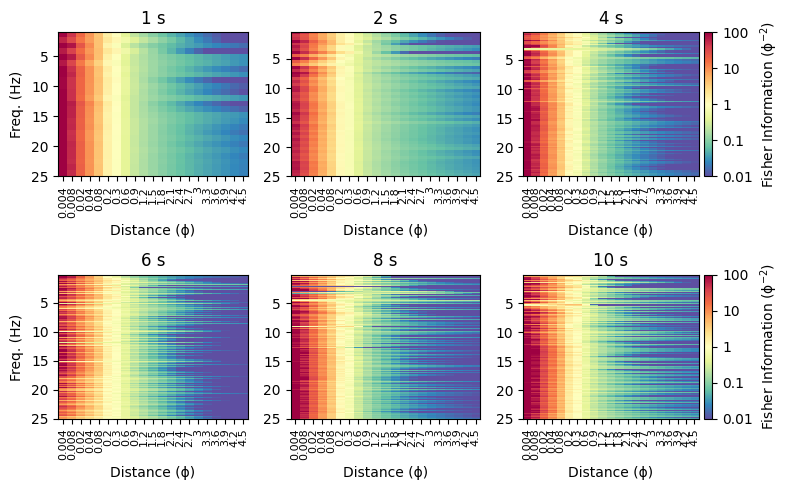

/nemo/lab/schaefera/working/tootoos/git/fisher-plumes/fisher_plumes_figs.py:652: RuntimeWarning: divide by zero encountered in log10
  im = ax.matshow(np.log10(I[ind_use]),


Wrote figs/su_high_pink_hann_series.pdf.


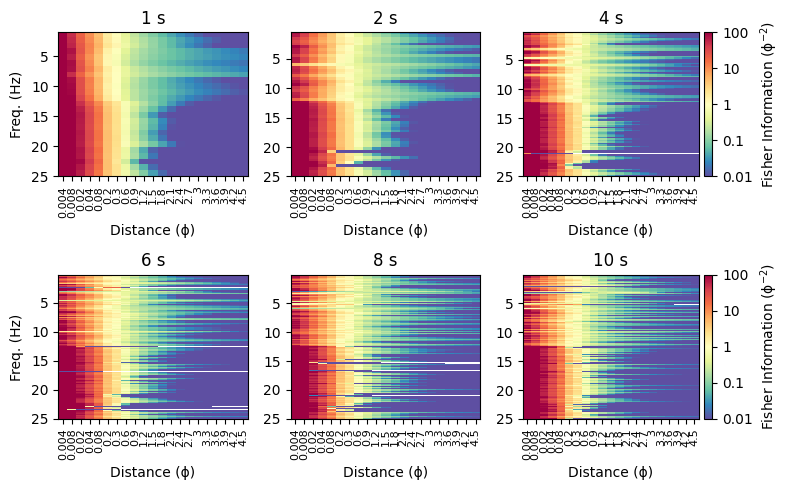

In [102]:
reload(fpf)
heatmap_range = defaultdict(lambda: [-2, log10(500)], {"cr":[-2,2], "su_high_pink":[-2,2]})
figsize       = defaultdict(lambda: (8,5), {"cr":(8,8)})
for ds, pr in proc.items():
    wnd_types = {fpt.get_window_name(f[1]) for f in pr}
    if len(wnd_types)>1:
        for wnd_type in wnd_types:
            fpf.plot_window_series(proc[ds], wnd_type, heatmap_range = heatmap_range[ds], figsize = figsize[ds])
            file_name = f"figs/{ds}_{wnd_type}_series.pdf"
            SAVEPLOTS and (savefig(file_name, bbox_inches='tight', pad_inches=0), flush(f"Wrote {file_name}."));
            sys.stdout.flush(); plt.show()

# Plot best frequency for each probe

/camp/home/tootoos/working/tootoos/conda-envs/py38/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1369: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return np.asarray(x, float)


Wrote figs/wnd_1sec/best_freq_bw.pdf.


/camp/home/tootoos/working/tootoos/conda-envs/py38/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1369: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return np.asarray(x, float)


Wrote figs/wnd_1sec/best_freq_cr.pdf.


/camp/home/tootoos/working/tootoos/conda-envs/py38/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1369: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return np.asarray(x, float)


Wrote figs/wnd_1sec/best_freq_su.pdf.


/camp/home/tootoos/working/tootoos/conda-envs/py38/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1369: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return np.asarray(x, float)


Wrote figs/wnd_1sec/best_freq_su_high_pink.pdf.


/camp/home/tootoos/working/tootoos/conda-envs/py38/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1369: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return np.asarray(x, float)


Wrote figs/wnd_1sec/best_freq_su_high_white.pdf.


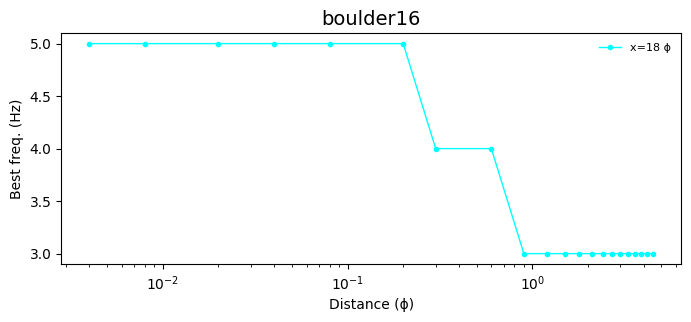

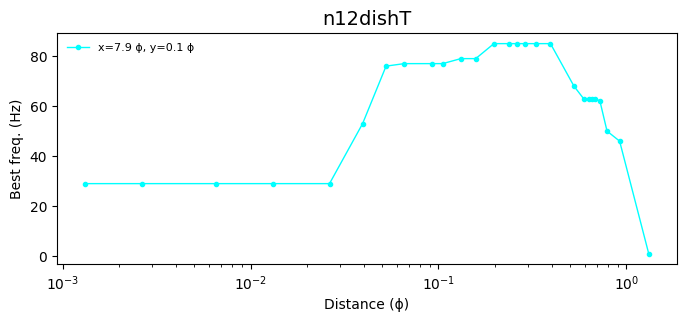

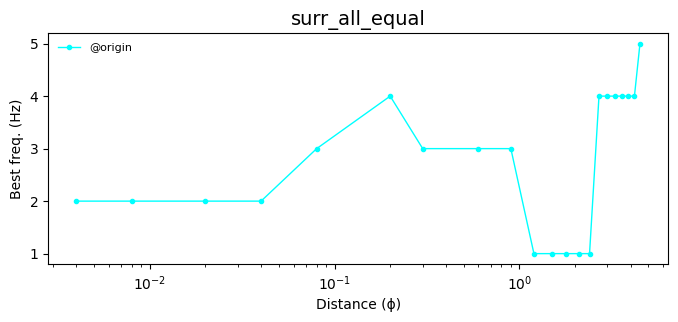

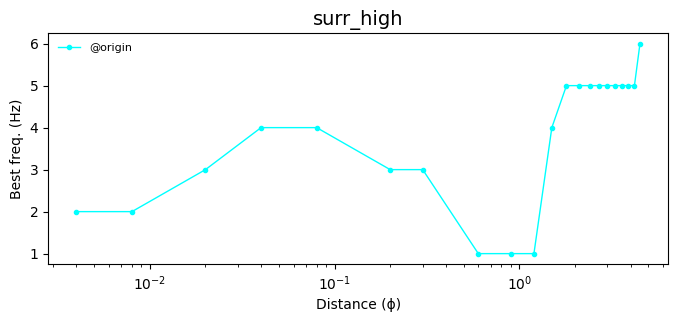

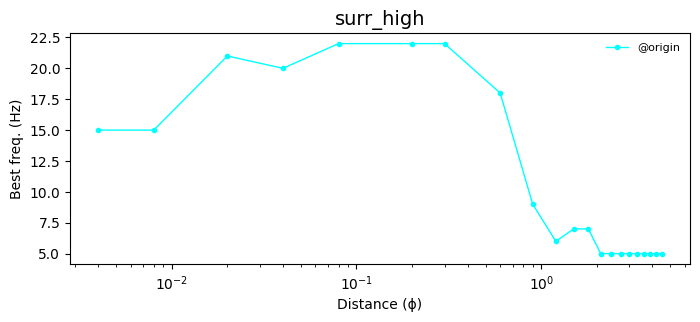

In [30]:
for k, F in sorted(data_wnd.items()):
    probe_coords = utils.d1(F.sims).get_used_probe_coords()
    probe_xcoords_sorted = sorted([p[0] for p in probe_coords])
    probe_names = utils.d1(F.sims).coord_strs
    n_probes = len(probe_coords)
    figure(figsize=(8,3))
    dd = F.I_dists/F.pitch.to(UNITS.um).magnitude
    for which_probe, (px,py) in enumerate(probe_coords):
        semilogx(dd, median(F.freqs[F.I_best_ifreqs[which_probe]][1:],axis=0),
                 "o-",markersize=3, linewidth=1, color = cm.cool(probe_xcoords_sorted.index(px)/max((n_probes-1),1)), label=probe_names[which_probe])
    xlabel("Distance (ϕ)")
    ylabel("Best freq. (Hz)")
    title(F.name, fontsize=14)
    legend(frameon=False, labelspacing=0, fontsize=8)
    file_name = f"{fig_dir}/best_freq_{k}.pdf"
    SAVEPLOTS and (savefig(file_name, bbox_inches='tight'), flush(f"Wrote {file_name}."));
        


# Plot the Power in each Signal

Wrote figs/wnd_1sec/spectra.pdf.


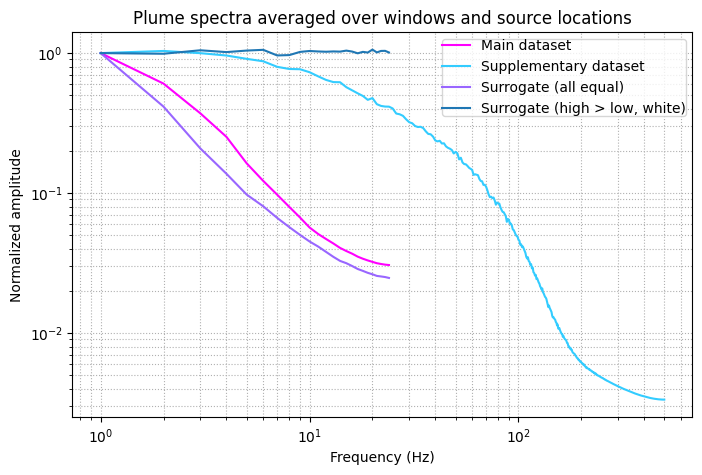

In [31]:
figure(figsize=(8,5))
for k, F in sorted(data_wnd.items()):
    if k == "su_high_pink": continue # Has the same spectrum as su.
    f = []
    for _, s in F.sims.items():
        fs = F.fs.to(UNITS.hertz).magnitude
        fr, ti, S = stft(s.data[:,iprb], fs = fs, window='boxcar',
                         nperseg=int(fs), noverlap=fs//2, boundary=None, padded=False)
        f.append(np.abs(S))
        
    f = np.array(f)
    a = np.mean(f,axis=-1).mean(axis=0)    
    loglog(fr[fr<fs/2][1:],a[fr<fs/2][1:]/a[1],
           label={"cr":"Supplementary dataset", "bw":"Main dataset", "su":"Surrogate (all equal)", "su_high_white":"Surrogate (high > low, white)", "su_high_pink":"Surrogate (high > low, pink)" }[k],
           color={"su_high_pink":"pink", "su_high_white":"C0", "su":cm.cool_r(0.4), "bw":cm.cool_r(0.0), "cr":cm.cool_r(0.8)}[k])
legend(borderpad=0)
xlabel("Frequency (Hz)")
ylabel("Normalized amplitude")
title("Plume spectra averaged over windows and source locations")
grid(True, which='both', linestyle=":")
file_name = f"{fig_dir}/spectra.pdf"
SAVEPLOTS and (savefig(file_name, bbox_inches='tight'), flush(f"Wrote {file_name}."));

# The End